In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [187]:
# Specify the first year we consider in our analysis
START_YEAR = 1970
# Specify career len to export file for
CAREER_LENGTH = 5
# Specify how long is the early career. Impacts which papers we take into account for early productivity and quality
EARLY_CAREER_LEN = 3
# For early career work, when do we stop counting citations. Impacts recognition
QUALITY_CUT_OFF = 5
# Success after 15 years. Impacts when we stop counting citations
SUCCESS_CUTOFF = 15

## 1. Load data

In [3]:
authorPublicationData = pd.read_csv('./data/author_publications_2017_asiansAsNone.txt')
print(authorPublicationData.shape)
authorPublicationData.head()

(9471668, 3)


author  year                                pub_id
0    graeme earl  2011  001c58d3-26ad-46b3-ab3a-c1e557d16821
1   gareth beale  2011  001c58d3-26ad-46b3-ab3a-c1e557d16821
2      m. nasser  2009  001c8744-73c4-4b04-9364-22d31a10dbf1
3   faisal zaman  2009  001c8744-73c4-4b04-9364-22d31a10dbf1
4  altaf hossain  2009  001c8744-73c4-4b04-9364-22d31a10dbf1

In [4]:
authorCitationsData = pd.read_csv('./data/citations_2017_asiansAsNone.txt')
authorCitationsData.head()

id1                                   id2  \
0  1fcd3d7f-1bb7-4347-914e-e23adb1e1a59  5065f1e8-0e2e-4e20-9866-2b5067d321dc   
1  1fcd3d7f-1bb7-4347-914e-e23adb1e1a59  cf862fd8-9204-4e44-9639-2d067c247539   
2  1fcd3d7f-1bb7-4347-914e-e23adb1e1a59  f19127f8-3d3a-4a9e-9580-c1d3e1e05141   
3  03b1d66a-b1fc-4d99-9904-9405695cc2ae  09991de0-c00f-49cf-a88a-6515943b0843   
4  03b1d66a-b1fc-4d99-9904-9405695cc2ae  156173f6-35eb-44f6-bc75-7c205153b6f0   

   year  
0  1990  
1  1990  
2  1990  
3  1994  
4  1994

In [5]:
print('Authors# - ',authorPublicationData['author'].nunique())
print('Years# - ',authorPublicationData['year'].nunique())
print('Publications# - ',authorPublicationData['pub_id'].nunique())

Authors# -  1704919
Years# -  83
Publications# -  3078230


## 2. Criteria for author removal

In [6]:
groupByAuthor = authorPublicationData.groupby(['author'])

groupByAuthorMinYearData = groupByAuthor['year'].min()
groupByAuthorMaxYearData = groupByAuthor['year'].max()
groupByAuthorCountPublicationsData = groupByAuthor['pub_id'].count()

In [7]:
authorGroupedData = groupByAuthorMinYearData.to_frame(name='start_year')
authorGroupedData['end_year'] = groupByAuthorMaxYearData
authorGroupedData['num_pub'] = groupByAuthorCountPublicationsData
authorGroupedData = authorGroupedData.reset_index()
print('Total rows -                ', authorGroupedData.shape)

authorGroupedData = authorGroupedData[authorGroupedData["start_year"] >= START_YEAR]
print('After removing all < 1970 - ', authorGroupedData.shape)

authorGroupedData = authorGroupedData.drop_duplicates()
print('After removing duplicates - ', authorGroupedData.shape)

authorGroupedData = authorGroupedData.dropna(how='any')
print("After droping na -          ", authorGroupedData.shape)

authorGroupedData.head()

Total rows -                 (1704919, 4)
After removing all < 1970 -  (1699352, 4)
After removing duplicates -  (1699352, 4)
After droping na -           (1699352, 4)


author  start_year  end_year  num_pub
0       'maseka lesaoana        2001      2015        2
1  (max) zong-ming cheng        2009      2011        2
2       (zhou) bryan bai        2011      2012        2
3        a aart blokhuis        1992      2005        2
4             a ahrabian        2017      2017        1

In [8]:
# Adding one here to have career length be at least one. So 3 years career means year1, year2, year3.
authorGroupedData["career_length"] = authorGroupedData['end_year'] - authorGroupedData['start_year'] + 1

### Remove authors by inactivity in specific career ages

In [9]:
#TODO We changed our mind and kept the old way to filter authors - career len

In [12]:
#TODO add removing people inactive for X years

In [10]:
# groupByAuthorYear = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

In [11]:
# groupByAuthorYear.head()

### Career length distribution

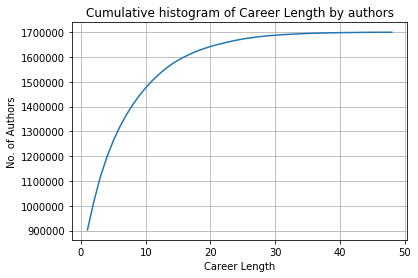

In [13]:
careerLengthDist = authorGroupedData.groupby(["career_length"])['author'].count()
temp = careerLengthDist.cumsum()  
ax = temp.plot(grid=True, title='Cumulative histogram of Career Length by authors')
ax.set_xlabel('Career Length')
ax.set_ylabel('No. of Authors')

plt.show()

### Filter and Save filtered data about authors

In [135]:
credible_authors = authorGroupedData[authorGroupedData['career_length'] >= CAREER_LENGTH]

In [17]:
credible_authors.to_csv('derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv',
                    index=False, encoding='utf-8')

In [18]:
# Quick load
# credible_authors = pd.read_csv('data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')


### Remove author from publications

In [19]:
authorPublicationData = authorPublicationData.loc[authorPublicationData.author.isin(credible_authors.author)]

In [20]:
print(authorPublicationData.shape)

(7505827, 3)


In [181]:
authorPublicationData.to_csv('derived-data/author-publications-atleast-'+ str(CAREER_LENGTH)+'-year.csv', index=False)

In [23]:
# Quick load
# authorPublicationData = pd.read_csv('derived-data/author-publications-atleast-'+ str(CAREER_LENGTH)+'-year.csv')

## 3. Generate a new citation network

### Generate Author->Paper network

In [24]:
# We need data about how many times an author has been cited
# For every authors publication, i merge all citations
final_citation_count_from_ids = authorPublicationData.merge(authorCitationsData, left_on='pub_id', 
                                                            right_on='id2', how='inner', suffixes=('_pub', '_cit'))

In [25]:
final_citation_count_from_ids.drop_duplicates(inplace=True)

#### Remove errors in citation data (years published vs years cited)

In [26]:
# Published before cited - NORMAL
print(final_citation_count_from_ids.shape)
num_normal = final_citation_count_from_ids[final_citation_count_from_ids.year_pub <= final_citation_count_from_ids.year_cit].shape
print(num_normal)

(67365510, 6)
(66898327, 6)


In [27]:
# Published after cited - WRONG
num_wrong = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit].shape
print(num_wrong)

(467183, 6)


In [28]:
print("Percentage of citations to be removed: ", num_wrong[0]*100/(num_normal[0]+num_wrong[0]))
print("Less than one percent")

Percentage of citations to be removed:  0.693504732614657
Less than one percent


In [29]:
cit_wrong_df = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit]

In [30]:
cit_wrong = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit].index

In [31]:
final_citation_count_from_ids.drop(cit_wrong, inplace=True)

assert num_normal[0] == final_citation_count_from_ids.shape[0], "The number of citations doesnt match"

In [32]:
final_citation_count_from_ids.columns

Index(['author', 'year_pub', 'pub_id', 'id1', 'id2', 'year_cit'], dtype='object')

#### Save

In [33]:
# final_citation_count_from_ids.to_csv('./data/authors_cited_by_papers_2017_asiansAsNone_by_daniel.txt',
#                                      columns=['author', 'year_pub', 'pub_id', 'id1', 'year_cit'], index=False)

final_citation_count_from_ids[['author', 'id1', 'id2', 'year_cit']].drop_duplicates().to_csv('derived-data/author-paper-citations-cleaned.csv', 
                                                                                   index=False)

# final_citation_count_from_ids.drop_duplicates(subset=['author_cited', 'pub_id_cited', 'pub_id_citing', 'author_citing'],
#                                               inplace=True)

In [34]:
# Quick load
# final_citation_count_from_ids = pd.read_csv('derived-data/paper-paper-citations-cleaned.csv')

In [35]:
# drop duplicates on id1,id2 because we only care about paper->paper citations
paper_citation_count = final_citation_count_from_ids.drop_duplicates(subset=['id1', 'id2']).groupby('id2')['id1'].count()
paper_citation_count.to_csv('derived-data/paper-citation-count.csv')

Its important to keep using this file for citations. As it has bad entries removed

### Generate Author->Author network

In [37]:
# # To generate an author->author citation network
# # For every citation an author received, merge in all the authors that cited him
# # TODO Should we be filtering citations? Do we include them all? We do drop ones cited before published
# final_citation_count_from_ids = final_citation_count_from_ids.merge(authorPublicationData, left_on='id1', 
#                                                                     right_on='pub_id', how='left', suffixes=('_cited', '_citing'))
# final_citation_count_from_ids.to_csv('./derived-data/author-author-citations.csv',
#                                      columns=['author_cited', 'author_citing', 'year_cit'], index=False)

In [36]:
final_citation_count_from_ids.head()

author  year_pub                                pub_id  \
0     graeme earl      2011  001c58d3-26ad-46b3-ab3a-c1e557d16821   
1    gareth beale      2011  001c58d3-26ad-46b3-ab3a-c1e557d16821   
18   faisal zaman      2009  001c8744-73c4-4b04-9364-22d31a10dbf1   
19   faisal zaman      2009  001c8744-73c4-4b04-9364-22d31a10dbf1   
20  altaf hossain      2009  001c8744-73c4-4b04-9364-22d31a10dbf1   

                                     id1  \
0   16870052-7e2e-4bbc-beeb-21e493bea221   
1   16870052-7e2e-4bbc-beeb-21e493bea221   
18  49ec0c15-7a9d-4378-a26a-f5063567b519   
19  ae0b4e3d-305d-4fb8-9847-60dcc9a9ec44   
20  49ec0c15-7a9d-4378-a26a-f5063567b519   

                                     id2  year_cit  
0   001c58d3-26ad-46b3-ab3a-c1e557d16821      2015  
1   001c58d3-26ad-46b3-ab3a-c1e557d16821      2015  
18  001c8744-73c4-4b04-9364-22d31a10dbf1      2013  
19  001c8744-73c4-4b04-9364-22d31a10dbf1      2014  
20  001c8744-73c4-4b04-9364-22d31a10dbf1      2013

### Group citations over authors and years

In [207]:
citations_year_auth = final_citation_count_from_ids.groupby(['author', 'year_cit'])['id1'].count()


In [208]:
citations_year_auth = citations_year_auth.reset_index().merge(credible_authors[['author', 'num_pub']], on='author')

In [209]:
citations_year_auth.head()

author  year_cit  id1  num_pub
0  'maseka lesaoana      2002    1        2
1  'maseka lesaoana      2003    1        2
2  'maseka lesaoana      2004    1        2
3  'maseka lesaoana      2005    2        2
4  'maseka lesaoana      2006    4        2

In [210]:
citations_year_auth = citations_year_auth.rename(columns={'id1':'cit_count'})

citations_year_auth[['author', 'year_cit', 'cit_count']].to_csv('derived-data/authors-perYear-citations-atleast-'+str(CAREER_LENGTH)+'-year.csv', index=False)

In [211]:
citations_year_auth = citations_year_auth.groupby(['author', 'year_cit'])['cit_count'].sum()

## Early career analysis

In [182]:
combined = final_citation_count_from_ids.merge(credible_authors[['author', 'start_year']], on='author', how='inner')

In [183]:
combined.head()

author  year_pub                                pub_id  \
0  graeme earl      2011  001c58d3-26ad-46b3-ab3a-c1e557d16821   
1  graeme earl      2011  6af505cf-727f-47f9-afea-772af2928086   
2  graeme earl      2009  3ac1f00f-6830-42e9-b6f9-944f00a71b3c   
3  graeme earl      2009  3133714c-f979-4d84-9224-97361cf053ab   
4  graeme earl      2009  3133714c-f979-4d84-9224-97361cf053ab   

                                    id1                                   id2  \
0  16870052-7e2e-4bbc-beeb-21e493bea221  001c58d3-26ad-46b3-ab3a-c1e557d16821   
1  7be205bf-95e7-4baa-b800-770684720dec  6af505cf-727f-47f9-afea-772af2928086   
2  523e22e9-0b2f-439f-bad6-dd8037364f44  3ac1f00f-6830-42e9-b6f9-944f00a71b3c   
3  001c58d3-26ad-46b3-ab3a-c1e557d16821  3133714c-f979-4d84-9224-97361cf053ab   
4  523e22e9-0b2f-439f-bad6-dd8037364f44  3133714c-f979-4d84-9224-97361cf053ab   

   year_cit  start_year  
0      2015        2009  
1      2014        2009  
2      2010        2009  
3      2011        2009  
4      2010        2009

In [184]:
combined.drop_duplicates(subset=['author', 'id1', 'id2'], inplace=True)

In [185]:
credible_authors.head()

author  start_year  end_year  num_pub  career_length  \
0  'maseka lesaoana        2001      2015        2             15   
1   a aart blokhuis        1992      2005        2             14   
2        a min tjoa        1979      2017      191             39   
3  a-imam al-sammak        1992      2006        3             15   
4        a-long jin        2011      2016        9              6   

   early_career_qual  early_career_prod  \
0                5.0                  1   
1                0.0                  1   
2                0.0                  1   
3                0.0                  1   
4                0.0                  1   

                        early_career_pubs  early_career_rec gender  \
0  [4ff8ca7b-16b7-4bc8-b235-1eeac9b2aefa]                 0   none   
1  [f80ada7b-a8ef-43b0-b1c7-5c35f8cd0ea8]                 0   none   
2  [608eb4db-5623-4467-aba6-b7762abefe20]                 0   none   
3  [14528920-bfbd-457c-ace2-b4422ea6aafd]                 0      m   
4  [86a055b7-36a9-4b03-b9d4-71725e5d5b0d]                 0   none   

   final_citation_count  
0                  25.0  
1                   0.0  
2                 799.0  
3                   0.0  
4                  19.0

In [186]:
combined.shape

(66898327, 7)

In [141]:
combined_early_quality = combined[(combined.year_pub < combined.start_year + EARLY_CAREER_LEN) &
         (combined.year_cit < combined.start_year + QUALITY_CUT_OFF)]

In [144]:
early_career_quality = combined_early_quality.groupby('author')['id1'].count()

early_career_quality = early_career_quality.rename('early_career_qual')
early_career_quality = early_career_quality.reset_index()
credible_authors = credible_authors.merge(early_career_quality, on='author', how='left')

In [148]:
credible_authors['early_career_qual'] = credible_authors['early_career_qual'].fillna(0)

In [188]:
combined_succ_after_15y = combined[combined.year_cit < combined.start_year + SUCCESS_CUTOFF]

In [190]:
combined_succ_after_15y.head()

author  year_pub                                pub_id  \
0  graeme earl      2011  001c58d3-26ad-46b3-ab3a-c1e557d16821   
1  graeme earl      2011  6af505cf-727f-47f9-afea-772af2928086   
2  graeme earl      2009  3ac1f00f-6830-42e9-b6f9-944f00a71b3c   
3  graeme earl      2009  3133714c-f979-4d84-9224-97361cf053ab   
4  graeme earl      2009  3133714c-f979-4d84-9224-97361cf053ab   

                                    id1                                   id2  \
0  16870052-7e2e-4bbc-beeb-21e493bea221  001c58d3-26ad-46b3-ab3a-c1e557d16821   
1  7be205bf-95e7-4baa-b800-770684720dec  6af505cf-727f-47f9-afea-772af2928086   
2  523e22e9-0b2f-439f-bad6-dd8037364f44  3ac1f00f-6830-42e9-b6f9-944f00a71b3c   
3  001c58d3-26ad-46b3-ab3a-c1e557d16821  3133714c-f979-4d84-9224-97361cf053ab   
4  523e22e9-0b2f-439f-bad6-dd8037364f44  3133714c-f979-4d84-9224-97361cf053ab   

   year_cit  start_year  
0      2015        2009  
1      2014        2009  
2      2010        2009  
3      2011        2009  
4      2010        2009

In [192]:
succ_after_15y = combined_succ_after_15y.groupby('author')['id1'].count()

In [195]:
succ_after_15y = succ_after_15y.rename('succ_after_15y')
succ_after_15y = succ_after_15y.reset_index()
credible_authors = credible_authors.merge(succ_after_15y, on='author', how='left')

In [149]:
def get_early_career_prod(row, early_career_len):
    early_prod = 0
    author = row.author
    start_year = row['start_year']
    year_num_pub = author_year_numPub[author]
    for year in range(early_career_len):
        if start_year + year in year_num_pub:
            early_prod += year_num_pub[start_year + year]
    return early_prod

In [150]:
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

In [151]:
%%time
credible_authors['early_career_prod'] = credible_authors.apply(lambda x: get_early_career_prod(x, EARLY_CAREER_LEN), axis=1)

CPU times: user 2min 41s, sys: 1.56 s, total: 2min 43s
Wall time: 2min 43s


In [152]:
def get_early_publications(row, early_career_len):
    early_pubs = []
    author = row.author
    start_year = row['start_year']
    year_pub_list = author_year_publications[author]
    for year in range(early_career_len):
        if start_year + year in year_pub_list:
            early_pubs.extend(year_pub_list[start_year + year])
    return early_pubs

In [153]:
author_year_publications = authorPublicationData.groupby(['author', 'year'])['pub_id'].apply(list)

In [154]:
%%time
credible_authors['early_career_pubs'] = credible_authors.apply(lambda x: get_early_publications(x, EARLY_CAREER_LEN), axis=1)

CPU times: user 2min 53s, sys: 2.36 s, total: 2min 56s
Wall time: 2min 56s


In [202]:
def get_early_career_recognition(row, early_career_len):
    early_rec = 0
    author = row.author
    print(author)
    start_year = row['start_year']
    if author in citations_year_auth:
        year_num_cit = citations_year_auth[author]
        print(year_num_cit)
    else:
        return 0
    for year in range(early_career_len):
        if start_year + year in year_num_cit:
            early_rec += year_num_cit[start_year + year]
    return early_rec

In [203]:
%%time
credible_authors['early_career_rec'] = credible_authors.apply(lambda x: get_early_career_recognition(x, EARLY_CAREER_LEN), axis=1)

'maseka lesaoana
a aart blokhuis
a min tjoa
a-imam al-sammak
a-long jin
a-nasser ansari
a-xing zhu
a. a. (louis) beex
a. a. abdel-hamid
a. a. abouelsoud
a. a. adekunle
a. a. agboola
a. a. badr
a. a. ball
a. a. belevantsev
a. a. c. c. pais
a. a. dakhel
a. a. diwan
a. a. dosiyev
a. a. el-bary
a. a. el-harby
a. a. elsadany
a. a. frank
a. a. goldstein
a. a. gusev
a. a. hemeda
a. a. hujeirat
a. a. j. marley
a. a. jennifer adgey
a. a. kaposi
a. a. khan
a. a. klyachko
a. a. kosti
a. a. kranenburg
a. a. kytmanov
a. a. lopez
a. a. madkour
a. a. mousa
a. a. nacci
a. a. naik
a. a. nasr
a. a. nippun kumaar
a. a. oduwole
a. a. pashilkar
a. a. perachio
a. a. polezhaev
a. a. ramadan
a. a. safavi
a. a. salama
a. a. salimov
a. a. soliman
a. a. waskita
a. a. wray
a. a. zaidan
a. abbas
a. abdeldaim
a. abdellatif
a. abdollahi
a. abdullah
a. abkar
a. abraham
a. abrizah
a. adam
a. adam ding
a. adibi
a. afshar
a. agarwal
a. aggarwal
a. aggoun
a. aglic aljinovic
a. agrawal
a. aguado
a. aguilar
a. agung julius

aaron m. johnson
aaron m. newman
aaron m. rosenfeld
aaron m. smalter
aaron m. tenenbaum
aaron m. wendelboe
aaron m. zorn
aaron mannes
aaron marback
aaron marcus
aaron marks
aaron mavrinac
aaron maxwell andrews
aaron mccoy
aaron mcfadyen
aaron melman
aaron meurer
aaron meyerowitz
aaron michaux
aaron mills
aaron mininger
aaron montero
aaron morris
aaron myers
aaron n. chang
aaron n. kaplan
aaron n. ng
aaron n. siegel
aaron nathan
aaron ogus
aaron opdyke
aaron p. gerratt
aaron p. hurst
aaron p. mitchell
aaron p. schultz
aaron p. shon
aaron paloski
aaron parness
aaron partridge
aaron paulos
aaron peeler
aaron potechin
aaron powers
aaron r. bradley
aaron r. dinner
aaron r. quinlan
aaron r. seitz
aaron read
aaron rice
aaron robertson
aaron roth
aaron ruß
aaron s. cohen
aaron s. crandall
aaron s. field
aaron s. heller
aaron s. master
aaron s. veenstra
aaron s. w. wong
aaron s. wang
aaron saas
aaron sampson
aaron sawdey
aaron schein
aaron schiff
aaron schild
aaron schulman
aaron searle
aaron s

abhishek kolagunda
abhishek kulkarni
abhishek kumar
abhishek kumar 1
abhishek kumar 3
abhishek kumar dubey
abhishek kumar gangwar
abhishek kumar jain
abhishek majumder
abhishek midya
abhishek mishra
abhishek mitra
abhishek mukherji
abhishek murarka
abhishek murthy
abhishek n. tripathi
abhishek nagar
abhishek narain singh
abhishek p. chhetri
abhishek parakh
abhishek patil
abhishek prakash tayal
abhishek rai
abhishek rana
abhishek ranjan
abhishek rawat
abhishek ray
abhishek rege
abhishek roy
abhishek sainani
abhishek samanta
abhishek sarkar
abhishek sharma
abhishek singh
abhishek singh rana
abhishek singhal
abhishek singharoy
abhishek sinha
abhishek somani
abhishek srivastav
abhishek srivastava
abhishek swaroop
abhishek tandon
abhishek thakur
abhishek tiwari
abhishek tripathi
abhishek udupa
abhishek vahadane
abhishek vaish
abhishek verma
abhishek yadav
abhradeep thakurta
abhrajit ghosh
abhranil maiti
abhronil sengupta
abhyudai singh
abhyuday mandal
abi james
abid ali khan
abid ali minhas

aditya krishna menon
aditya kulkarni
aditya kumar
aditya kumar mishra
aditya kumar sehgal
aditya kurve
aditya mahajan
aditya mathur
aditya mavlankar
aditya mittal
aditya mogadala
aditya n. das
aditya n. saharia
aditya nigam
aditya p. mathur
aditya pal
aditya pancholi
aditya ponnada
aditya pradhan
aditya prakash
aditya raj
aditya ramamoorthy
aditya ramana rachakonda
aditya ramesh
aditya rao
aditya rawal
aditya reddy
aditya s. gadre
aditya sankar
aditya sharma
aditya shastri
aditya singh
aditya sriram
aditya sundarrajan
aditya tadakaluru
aditya tatu
aditya tayal
aditya telang
aditya tiwari
aditya trivedi
aditya umbu tana amah
aditya v. nori
aditya v. padaki
aditya v. thakur
aditya vaidya
aditya vailaya
aditya varma
aditya vashistha
aditya velivelli
aditya vempaty
aditya verma
aditya wagh
aditya yadav
aditya zutshi 1
adityanand guntuboyina
adityasankar medury
adityo prakosa
adiwijaya
adiyan mujibiya
adja ferreira de andrade
adlane habed
adlen ksentini
adlen loukil
adler diniz de souza
adl

ahmad ghanbari
ahmad ghany
ahmad gharanjik
ahmad ghasemloonia
ahmad ghazal
ahmad ghazawneh
ahmad gholami
ahmad ghoneim
ahmad gomaa
ahmad h. el khateb
ahmad h. nasri
ahmad habibizad navin
ahmad hably
ahmad haddad
ahmad haidar
ahmad haj mosa
ahmad hakimi
ahmad hamad
ahmad hammad
ahmad harb
ahmad hasnah
ahmad hassan
ahmad hawalah
ahmad hemami
ahmad hemmati
ahmad hoirul basori
ahmad hoorfar
ahmad hossny
ahmad humayun
ahmad husseini
ahmad i. abu-el-haija
ahmad i. amayreh
ahmad i. jarrah
ahmad ibrahim 1
ahmad izani bin md. ismail
ahmad izani md. ismail
ahmad j. reeves
ahmad jafarabadi
ahmad jafari samimi
ahmad jafarian
ahmad jalal
ahmad jamal
ahmad jbara
ahmad k. naimzada
ahmad kalhor
ahmad kamal
ahmad kamal aijazi
ahmad kamil bin mahmood
ahmad kamil mahmood
ahmad karawash
ahmad karfoul
ahmad kayed
ahmad keshavarz
ahmad keshtkar
ahmad khadem zadeh
ahmad khadem-zadeh
ahmad khademzadeh
ahmad khalil
ahmad khasawneh
ahmad khayyat
ahmad khodayari-rostamabad
ahmad khonsari
ahmad khoshnevis
ahmad l

ajay mathur
ajay mittal
ajay mohindra
ajay mysore
ajay n. bhoj
ajay n. jain
ajay nagesh
ajay nair
ajay narayanan
ajay p. malshe
ajay pal singh rathore
ajay pal singh virk
ajay panicker
ajay parikh
ajay patel
ajay patrikar
ajay prasad
ajay r. dani
ajay raina
ajay rana
ajay s. gor
ajay s. pillai
ajay s. vinze
ajay sethi
ajay shah
ajay sharma
ajay shekhawat
ajay singh
ajay somkuwar
ajay srinivasamurthy
ajay subramanian
ajay taparia
ajay thampi
ajay tripathi
ajay ummat
ajay v. bakre
ajay verma
ajaya kumar tripathy
ajaya neupane
ajaz hussain mir
ajchara dechaboon
ajeesh p. kurian
ajeet grewal
ajeet parhar
ajeet rohatgi
ajeet singh
ajei s. gopal
ajey kumar
ajin jirachiefpattana
ajinkya bhave
ajinkya kale
ajinkya kulkarni
ajit a. diwan
ajit appari
ajit ashok shenvi
ajit bapat
ajit danti
ajit dingankar
ajit gopalakrishnan
ajit gupte
ajit k. chaturvedi
ajit k. mandal
ajit k. patankar
ajit k. verma
ajit kambil
ajit kumar
ajit kumar chaturvedi
ajit kumar nayak
ajit kumar rout
ajit kumar sahoo
aji

alan b. anderson
alan b. arehart
alan b. bradley
alan b. craig
alan b. tanner
alan b. tickle
alan b. williams
alan bailin
alan bain
alan ball
alan bannon
alan barbieri
alan barhorst
alan barnes
alan barr
alan bawden
alan bell
alan bennett
alan benson
alan berry
alan bivens
alan blackwell
alan blair
alan blatt
alan borning
alan both
alan boughey
alan boulanger
alan bourke
alan bowling
alan bradshaw
alan bridge
alan brine
alan brown
alan brunton
alan bundy
alan burns
alan c. benander
alan c. bovik
alan c. calder
alan c. cheng
alan c. evans
alan c. f. colchester
alan c. gibbs
alan c. h. ling
alan c. hindmarsh
alan c. kay
alan c. l. yu
alan c. lin
alan c. nelson
alan c. schultz
alan c. seabaugh
alan c. shaw
alan c. tucker
alan c. w. lau
alan calvitti
alan cameron wills
alan cannon
alan carle
alan carlin
alan chalmers
alan chamberlain
alan chang
alan chapman
alan chappell
alan chen
alan cheung
alan chi wai wong
alan chia-lung chen
alan chin-chen chang
alan choi
alan chong
alan christoffels


alberto un jan
alberto uriarte
alberto urueña-lópez
alberto v. donati
alberto valderruten
alberto valdes-garcia
alberto vale
alberto valero-gomez
alberto vallan
alberto valli
alberto vancheri
alberto varone
alberto venturi
alberto venturini
alberto verdejo
alberto vigato
alberto vigneron-tenorio
alberto villa
alberto villegas
alberto yufera
alberto yukinobu hata
alberto zambelli
alberto zanardo
alberto zanella
alberto zanoni
alberto zanutto
alberto zurita
alberto álvarez
albertus c. den brinker
albertus hendrawan adiwahono
albertus s. j. helberg
albin ahmeti
albin j. gasiewski
albin l. jones
albin petit
albin sandelin
albin zuccato
albina orlando
albino altomare
albino marques
albino martínez-sibaja
albino mazzone
albino nogueiras
albino nogueiras rodriguez
alborz geramifard
albrecht beutelspacher
albrecht blaser
albrecht böttcher
albrecht enders
albrecht fortenbacher
albrecht gebhardt
albrecht gensior
albrecht gnauck
albrecht heeffer
albrecht hoene
albrecht hübler
albrecht irle
albrec

alessandro rucco
alessandro rudi
alessandro russo 1
alessandro russo 2
alessandro s. spinelli
alessandro saccon
alessandro saetti
alessandro saffiotti
alessandro salmi
alessandro salvi
alessandro salvini
alessandro sanginario
alessandro santana martins
alessandro santaniello
alessandro sarti
alessandro savino
alessandro savoia
alessandro sbuelz
alessandro scuderi
alessandro selvaggio
alessandro sergi
alessandro serio
alessandro serpi
alessandro sette
alessandro sicco
alessandro siciliano
alessandro silvestri
alessandro sivieri
alessandro solimando
alessandro sona
alessandro soranzo
alessandro sordoni
alessandro sorichetta
alessandro sorniotti
alessandro soro
alessandro sperduti
alessandro sperindé
alessandro spinetti
alessandro staino
alessandro stefano
alessandro strano
alessandro taddei
alessandro tarello
alessandro tasora
alessandro tavano
alessandro testa
alessandro tognetti
alessandro toigo
alessandro tomasi
alessandro tomasoni
alessandro tomazic
alessandro tommasi
alessandro torc

alexander mishchenko
alexander mitsos
alexander moffett
alexander moibenko
alexander moiseev
alexander mojaev
alexander molchanov
alexander moopenn
alexander morgan
alexander mortl
alexander moshchuk
alexander moshe rabinovich
alexander moskovsky
alexander mozeika
alexander mädche
alexander müller
alexander münch
alexander münchau
alexander n. cartwright
alexander n. churilov
alexander n. daryin
alexander n. dolia
alexander n. donev
alexander n. dudin
alexander n. fuchs
alexander n. gorban
alexander n. grishkov
alexander n. kalashnikov
alexander n. korotkov
alexander n. lozhkin
alexander n. malyshev
alexander n. pavlov
alexander n. prokopenya
alexander n. rybalov
alexander n. silchenko
alexander n. zemliachenko
alexander nadel
alexander nakhimovsky
alexander nareyek
alexander narr
alexander nazin
alexander nelson
alexander neubeck
alexander neumann
alexander neumeister
alexander ng
alexander nikitin
alexander nikov
alexander nilsson
alexander nittka
alexander nolte
alexander norta
alex

alexey gotsman
alexey gribovskiy
alexey gudimov
alexey gutin
alexey i. adamovich
alexey i. baranov
alexey i. nesvizhskii
alexey ignatiev
alexey k. mazur
alexey k. shaytan
alexey kalinov
alexey karimov
alexey karpov
alexey kashevnik
alexey khoryaev
alexey kolesnichenko
alexey kostin
alexey kreshchuk
alexey kuchumov
alexey kukanov
alexey kupriyanov
alexey kurakin
alexey kuznetsov
alexey kuznetsov 2
alexey l. lastovetsky
alexey lagunin
alexey lagunov
alexey lebedev
alexey loginov
alexey lopich
alexey lukashin
alexey lvov
alexey m. eroshkin
alexey m. shibeko
alexey markov
alexey maslov
alexey matveev
alexey mekler
alexey melnikov
alexey milovanov
alexey minin
alexey mishenin
alexey n. pavlov
alexey n. salnikov
alexey n. zhirabok
alexey nazarov
alexey nekrasov
alexey nikolaev
alexey novoradovsky
alexey onufriev
alexey ovchinnikov
alexey ozerov
alexey p. zhabko
alexey pavlov
alexey petrovsky
alexey pilipovecs
alexey podlasov
alexey pokrovskiy
alexey potapov
alexey poyda
alexey pryakhin
alexe

ali taleghani
ali tarhini
ali tavakoli
ali tavasoli
ali taylan cemgil
ali tekeoglu
ali telli
ali tfayli
ali tiss
ali tizghadam
ali tofigh
ali tokay
ali toker
ali torkamani
ali tufail
ali turan
ali turkyilmaz
ali türker
ali türkyilmaz
ali ufuk peker
ali uneri
ali utku pehlivan
ali uzun
ali vahdat
ali vahidian kamyad
ali vahit sahiner
ali vakilian
ali valehi
ali vatankhah barenji
ali w. k. sangawi
ali wagdy mohamed
ali wali
ali y. al-zahrani
ali y. duale
ali y. panah
ali yachir
ali yakhlef
ali yalcin
ali yapar
ali yassine
ali yaver
ali yazdian varjani
ali yazici
ali yener mutlu
ali yeon md shakaff
ali yildiz
ali younes
ali yousefi
ali yousnadj
ali z. khokhar
ali zahabi
ali zahir
ali zaidat
ali zakerolhosseini
ali zamani
ali zand
ali zandifar
ali zarei ghanavati
ali zeinal hamadani
ali zeki
ali zemouche
ali zia
ali ziaei
ali zifan
ali zilouchian
ali ziya alkar
ali zolfaghari
ali zolghadri
ali çalhan
ali çiltik
ali çivril
ali özen
ali özgün ok
ali özgür yilmaz
ali öztürk
ali ünlü
ali-akbar

altyeb altaher altyeb
aluir porfírio dal poz
aluisio i. r. fontes
aluizio f. r. araujo
aluizio f. r. araújo
aluizio fausto ribeiro araújo
alumit ishai
alun d. hughes
alun d. preece
alun evans
alun hubbard
alun l. lloyd
alun thomas
aluísio pinheiro
aluízio haendchen filho
alva erwin
alva l. couch
alvar saenz-otero
alvar vinacua
alvaro a. a. de salles
alvaro a. a. fernandes
alvaro a. cruz-cabrara
alvaro a. cárdenas
alvaro aguilera
alvaro arenas
alvaro barreiro
alvaro blanco-del-campo
alvaro bolivar
alvaro c. d. faria
alvaro cardenas
alvaro collet
alvaro corral
alvaro cortés-calabuig
alvaro d. taveira
alvaro de menezes sobreira neto
alvaro del val
alvaro e. arenas
alvaro e. campos
alvaro e. gil
alvaro e. monge
alvaro e. prieto
alvaro enrique garcia
alvaro escribano
alvaro espinal ortega
alvaro fernández
alvaro francisco huertas-rosero
alvaro garcia-piquer
alvaro garcía-martín
alvaro gomes
alvaro graves
alvaro guevara
alvaro gómez
alvaro gómez-pau
alvaro ivanoff
alvaro j. gonzález
alvaro l

amit misra
amit mital
amit mitra
amit mondal
amit mukherjee
amit mukhopadhyay
amit mushkin
amit nahar
amit nandi
amit narayan
amit p. jardosh
amit p. sawant
amit p. sheth
amit pal
amit pal singh
amit pande
amit pandey
amit patel
amit patil
amit patra
amit paul
amit pazgal
amit phadikar
amit poddar
amit prakash
amit prakash singh
amit purohit
amit raj
amit ramesh
amit ranjan trivedi
amit rao
amit ray
amit rechavi
amit roy
amit rudra
amit s. malegaonkar
amit sabne
amit sabnis
amit sachan
amit saha
amit sahai
amit sahoo
amit sahu
amit sanghani
amit sangroya
amit sasturkar
amit satpathy
amit sawant
amit saxena
amit sehgal
amit sengupta
amit sethi
amit shah
amit shaked
amit sharma
amit shesh
amit sheth
amit shirsat
amit shukla
amit singer
amit singh
amit singh 3
amit singhal
amit sinha
amit srivastava
amit stark
amit surana
amit suveer
amit thakkar
amit thawani
amit trivedi
amit u. sinha
amit v. deokar
amit vasudevan
amit verma
amit weinstein
amit x. garg
amit yadav
amit zoran
amita chatter

anantha chandrakasan
anantha narayanan
anantha p. chandrakasan
anantha raman krishnan
anantha simha
ananthakrishnan ramanathan
ananthanarayanan chockalingam
anantharaman balasubramanian
anantharaman kalyanaraman
anantharaman lakshminarayanan
anantharaman subbaraman
ananthram swami
anany levitin
ananya das
ananya kanjilal
ananya misra
ananya muddukrishna
ananya sen gupta
anar gasimov
anara sandygulova
anargyros chatzitofis
anargyros chryssanthou
anargyros garyfalos
anargyros krikelis
anargyros papageorgiou
anargyros plemenos
anargyros sarafopoulos
anargyros sideris
anargyros tsadimas
anarosa a. f. brandão
anarosa alves franco brandão
anarosa brandão
anarta ghosh
anas a. hamoui
anas abou el kalam
anas abu taleb
anas al-korj
anas al-nuaimi
anas al-rabadi
anas al-roubaiey
anas aloudat
anas altartouri
anas basalamah
anas bassam al-badareen
anas bouguecha
anas chaaban
anas f. alrawi
anas fattouh
anas hatim
anas kabbaj
anas kamoun
anas m. salhab
anas mahmoud
anas muhamad bostamam
anas n. al-r

andrea santori
andrea santoro
andrea santos-garcia
andrea saracino
andrea saroldi
andrea sattler-klein
andrea savigni
andrea sbarbati
andrea sboner
andrea scagliarini
andrea scarpa
andrea schaerf
andrea schafferhans
andrea schalk
andrea schankin
andrea scharnhorst
andrea schauerhuber
andrea scheidig
andrea schenk
andrea schenone
andrea schiffauerova
andrea schirru
andrea schmidt
andrea schmitz
andrea schwandt
andrea schweer
andrea schwertner charão
andrea sciaba
andrea sciarrone
andrea scoglio
andrea scorzoni
andrea scozzari
andrea seidl
andrea selinger
andrea semanicová
andrea semanicová-fenovcíková
andrea seraghiti
andrea serino
andrea serrani
andrea setzer
andrea sgarro
andrea simone
andrea simonetti
andrea simonetto
andrea simoni
andrea sindico
andrea soddu
andrea soltoggio
andrea soppera
andrea sorbara
andrea sorbi
andrea soricelli
andrea sosso
andrea spadaccini
andrea spinelli
andrea splendiani
andrea sportiello
andrea spoto
andrea sprlakova
andrea stefani
andrea sterbini
andrea 

andrei agapi
andrei alexandrescu
andrei alexandru
andrei alexandru enescu
andrei alexeevski
andrei anghelescu
andrei arion
andrei arusoaie
andrei asinowski
andrei b. khlopotine
andrei b. utkin
andrei bacs
andrei banciu
andrei barborica
andrei barbu
andrei bartic
andrei bautu
andrei belitski
andrei blinov
andrei bondarenko
andrei bourchtein
andrei brasoveanu
andrei bursuc
andrei c. jalba
andrei cimpian
andrei ciortea
andrei costa
andrei damian
andrei danilchenko
andrei de araújo formiga
andrei dinu
andrei doncescu
andrei draganescu
andrei dragomir
andrei e. gabrielian
andrei e. romashchenko
andrei f. kazakov
andrei fionov
andrei g. fedorov
andrei g. pakhomov
andrei gabrielov
andrei gagarin
andrei gheata
andrei giurgiu
andrei gorea
andrei grebennikov
andrei grigoriev
andrei hagiescu
andrei haidu
andrei homescu
andrei hossu
andrei hutanu
andrei i. holodny
andrei i. tolstykh
andrei iancu
andrei ilie
andrei iones
andrei irimia
andrei iu. bejan
andrei jalba
andrei karatkevich
andrei kazarov


andrew ravenscroft
andrew rechnitzer
andrew redd
andrew redfern
andrew reed
andrew reed stewart
andrew rees
andrew reeson
andrew remsen
andrew reynolds
andrew rice
andrew richards
andrew richardson
andrew robb
andrew roberts
andrew robertson
andrew robinson
andrew robson
andrew rock
andrew roczniak
andrew rodger
andrew rodriguez
andrew rosalsky
andrew rose
andrew rosen
andrew rosenberg
andrew rosoff
andrew ross
andrew roth
andrew rowley
andrew royal
andrew ruef
andrew runka
andrew rusek
andrew rusinko iii
andrew russell
andrew russo
andrew ryan
andrew s. allen
andrew s. cassidy
andrew s. clare
andrew s. davis
andrew s. fast
andrew s. forsberg
andrew s. fox
andrew s. french
andrew s. gibbons
andrew s. glassner
andrew s. gordon
andrew s. greene
andrew s. grimshaw
andrew s. holmes
andrew s. jones
andrew s. kanter
andrew s. karson
andrew s. lan
andrew s. ling
andrew s. miner
andrew s. nencka
andrew s. noetzel
andrew s. parker
andrew s. patrick
andrew s. tanenbaum
andrew s. targowski
andrew

andy d. pimentel
andy davis
andy dawson
andy dearden
andy devos
andy dewilde
andy dong
andy echenique
andy edmonds
andy evans
andy folens
andy g. lynch
andy galloway
andy gean ye
andy georges
andy gill
andy gimblett
andy gordon
andy h. lee
andy halliday
andy ham
andy hamilton
andy harris
andy harter
andy hayes
andy heath
andy heinig
andy hisgen
andy hon wai chun
andy hopper
andy hospodor
andy hunt
andy igonor
andy j. keane
andy j. stanford-clark
andy j. wathen
andy j. wellings
andy j. wills
andy jacobs
andy jinhua ma
andy jinqing yu
andy johnson
andy jones
andy ju an wang
andy kahn
andy kellens
andy kenner
andy kho
andy king
andy konwinski
andy koronios
andy kurth
andy kwarteng
andy lambrechts
andy lane
andy law
andy laws
andy lee
andy liaw
andy lin
andy linton
andy lock yen low
andy lomas
andy lowry
andy luse
andy lymer
andy lücking
andy m. connor
andy m. day
andy m. sarroff
andy m. tyrrell
andy m. yip
andy ma
andy macfarlane
andy marsh
andy mckinlay
andy mcmillin
andy miller
andy mil

anke xue
anke ziethe
anker helms jørgensen
anker lajer højberg
ankesh jain
ankica babic
ankireddy nalamalpu
ankit agarwal
ankit aggarwal
ankit agrawal
ankit ahuja
ankit anand
ankit arora
ankit bhamri
ankit chaudhary
ankit dubey
ankit garg
ankit goel
ankit goyal
ankit gupta
ankit gupta 1
ankit gupta 2
ankit gupta 3
ankit gureja
ankit jain
ankit kamal
ankit khandelwal
ankit khare
ankit kumar
ankit mehta
ankit mohan
ankit more
ankit pat
ankit patel
ankit sabharwal
ankit salgia
ankit sethia
ankit shah
ankit sharma
ankit singh
ankit singh rawat
ankit singla
ankit soni
ankit srivastava
ankit tyagi
ankita bhan
ankita chaturvedi
ankita jain
ankita jain bansal
ankita kumar
ankita likhyani
ankita mohapatra
ankita panwar
ankita singh
ankita singla
ankitkumar n. patel
anko börner
ankunda r. kiremire
ankur a. kulkarni
ankur agarwal
ankur agiwal
ankur agrawal
ankur bansal
ankur chattopadhyay
ankur datta
ankur dave
ankur dhanik
ankur dhawan
ankur doshi
ankur gandhe
ankur gautam
ankur goel
ankur goyal

annette m. payne
annette m. williams
annette mcgrath
annette meidell
annette mills
annette mossel
annette muetze
annette n. markham
annette payne
annette r. von jouanne
annette rios gonzales
annette scheel
annette schelten
annette sobel
annette spellerberg
annette stahl
annette sterr
annette stümpel
annette ten teije
annette tetmeyer
annette valentin
annette wagner
annette weintraub
annette winkel schwarz
annette witt
anney che
anni cai
anni coden
anni järvelin
anni k. vuorenkoski
anni koubek
anni r. bruss
anni rytkönen
anni-yasmin turhan
annia galano
annibal josé scavarda
annibal parracho sant'anna
annibale biggeri
annibale elia
annibale panichella
annica kristoffersson
annick bricaud
annick bureaud
annick choisier
annick dejaegere
annick dhooge
annick labarre-vila
annick laruelle
annick lesne
annick majchrowski
annick montanvert
annick panaye
annick penarier
annick pouquet
annick razafimandimby
annick sartenaer
annick timmermans
annick valibouze
annie a. m. cuyt
annie astié-vidal
ann

antonin guttman
antonin hermanek
antonin novak
antonin pavelka
antonin ponsich
antonina andreeva
antonina dattolo
antonina durfee
antonina kieleczawa
antonina kolokolova
antonina mitrofanova
antonina starita
antonine goumi
antonino augugliaro
antonino battaglia
antonino casile
antonino di gerlando
antonino famulari
antonino feitosa neto
antonino fiannaca
antonino freno
antonino giorgio spera
antonino greco
antonino la magna
antonino laudani
antonino lauria
antonino lo bue
antonino m. sommariva
antonino mario cassarà
antonino marvuglia
antonino maugeri
antonino mazzeo
antonino morassi
antonino musolino
antonino nespola
antonino nocera
antonino orsino
antonino raffone
antonino raucea
antonino rotolo
antonino rullo
antonino s. fiorillo
antonino sabetta
antonino salibra
antonino santos
antonino scandurra
antonino scuderi
antonino sgalambro
antonino staiano
antonino tripodi
antonino tumeo
antonino vaccaro
antonino vallesi
antonino virgillito
antonino zanette
antonio a. alonso
antonio a. arr

anuja arora
anuja dharmaratne
anuja kumar acharya
anuja sehgal
anuja soni
anujan varma
anukool lakhina
anukrati agrawal
anukriti bansal
anulekha dhara
anum ali
anunchai assawamakin
anuntapat anuntachai
anuoluwapo o. ajayi
anup agarwal
anup aprem
anup basu
anup biswas
anup c. mokashi
anup chalamalla
anup dandapat
anup das 1
anup dewanji
anup doshi
anup gangwar
anup ghosh
anup goyal
anup hosangadi
anup k. ghosh
anup k. kalia
anup k. sen
anup kale
anup kumar
anup kumar bandyopadhyay
anup kumar bhattacharjee
anup kumar das
anup kumar gogoi
anup kumar paul
anup kumar talukdar
anup mahurkar
anup mohan
anup nandy
anup p. jose
anup parikh
anup patel
anup rao
anup shrestha
anup singh
anup som
anup sood
anup thapa
anupam a. thatte
anupam agrawal
anupam basu
anupam bhattacharjee
anupam bhide
anupam biswas
anupam chanda
anupam chattopadhyay
anupam das
anupam datta
anupam dutta
anupam ghosh
anupam goyal
anupam guha
anupam gupta
anupam jain
anupam joshi
anupam karmakar
anupam kaul
anupam kumar
anupa

arkadiusz chrobot
arkadiusz ciesielski
arkadiusz danilecki
arkadiusz gertych
arkadiusz glowacki
arkadiusz hulewicz
arkadiusz janik
arkadiusz jestratjew
arkadiusz kawa
arkadiusz kowalski
arkadiusz lewicki
arkadiusz orlowski
arkadiusz poteralski
arkadiusz sitek
arkadiusz socala
arkadiusz sochan
arkadiusz stasiewicz
arkadiusz stopczynski
arkadiusz szarek
arkadiusz szymczak
arkadiusz tomczyk
arkadiusz w. luczyk
arkadiusz wisniewski
arkadiusz wojna
arkadiusz wójs
arkadiusz z. dudek
arkadiy morgenshtein
arkady a. chernyak
arkady b. khodursky
arkady b. zaslavsky
arkady bolotin
arkady borisov
arkady gonoskov
arkady kanevsky
arkady kopansky
arkady kryazhimskiy
arkady m. pertsov
arkady n. borisov
arkady pikovsky
arkady retik
arkady tsurkov
arkady yerukhimovich
arkady zgonnikov
arkaitz artetxe
arkaitz lareki
arkaitz ruiz-alvarez
arkaitz zubiaga
arkalgud ramaprasad
arkan abdulrahman
arkaprava basu
arko banerjee
arko ghosh
arko lucieer
arlei silva
arlen bankston
arlen n. long
arlen planting
arlene 

artur przelaskowski
artur rataj
artur rembiszewski
artur rocha
artur rot
artur russ
artur rygula
artur räpp
artur s. d'avila garcez
artur schiefer
artur schmidt
artur serra
artur sierszen
artur signell
artur silic
artur silva
artur sowa
artur starczewski
artur szymanski
artur teles de araújo
artur tomaszewski
artur wilk
artur wilkowski
artur wojciechowski
artur wymyslowski
artur zarzycki
artur zawlocki
artur zdunek
artur ziviani
artur ziólkowski
arturas dubickas
arturas janusauskas
arturas kaklauskas
arturas mazeika
arturas medeisis
arturas serackis
arturas ziemys
arturo a. fernandez-jaramillo
arturo a. rodriguez
arturo aquino
arturo azcorra
arturo baltazar
arturo berrones
arturo brunetti
arturo buscarino
arturo camacho
arturo carnicer
arturo carpi
arturo chavoya
arturo crespo
arturo de la escalera
arturo diaz-perez
arturo donate
arturo erdely
arturo espinosa
arturo espinosa-romero
arturo evangelista
arturo fernández
arturo filastò
arturo flores
arturo garcia-perez
arturo garcía
arturo

assaf schuster
assaf sella
assaf shacham
assaf zaritsky
assaf zeevi
assaf zomet
assalé adjé
assam pryseley
assane gueye
assef chmeiss
assefa m. melesse
assefaw hadish gebremedhin
assegid kidané
assel zh. akzhalova
assem a. m. bsoul
assem h. sonbol
assem kaylani
assen shulev
assensi oliva
asser n. tantawi
assi n'guessan
assia alexandrova
assia belbachir
assia ben shil
assia benabdallah
assia doudou
assia guezane-lakoud
assia hakem
assia hamadene
assia hamouda
assia hamzaoui
assia jaillard
assia mahboubi
assia mouloudi
assia rharbi
assia semmar
assia soukane
assia touil
assia tria
assim sagahyroon
assimakis k. leros
assion lawson-body
asso hamzehei
assunta tavernise
assya rousseva
assyr abdulle
asta adukaite
asta bäck
asta gindulyte
asta k. håberg
asta kazlauskiene
asta kybartaite
asta miklius
asta roseway
asta slotkiene
asta zelenkauskaite
aster wardhani
asterio k. tanaka
asterios a. liolios
asterios katsifodimos
asterios leonidis
asterios pantokratoras
asterios toutios
astghik hambarya

avinash malik
avinash mishra
avinash mungur
avinash parnandi
avinash patil
avinash ravichandran
avinash sahay
avinash samvedi
avinash shankar
avinash shankaranarayanan
avinash sharma
avinash sodani
avinash sridharan
avinash srinivasan
avinash t. suresh
avinash unnikrishnan
avinash vem
avinash vyas
avinatan hassidim
avinava dubey
avinoam borowsky
avinoam kolodny
avinoam mann
avinoam nir
aviral shrivastava
aviram dayan
aviran kadosh
avirup sil
avis h. cohen
avisekh banerjee
avishag gordon
avishai ceder
avishai henik
avishai mandelbaum
avishai sintov
avishai weiss
avishai wool
avishay tal
avishay traeger
avishek adhikari
avishek anand
avishek chatterjee
avishek das
avishek ghosh
avishek nag
avishek pal
avishek saha
avishkar misra
avishy carmi
avit kumar bhowmik
avital bechar
avital gutman
avital lann
aviv bergman
aviv hurvitz
aviv mezer
aviv nisgav
aviv regev
aviv segev
aviv shachak
aviv tamar
aviv zohar
aviva abosch
avivit levy
avleen singh bijral
avneesh agrawal
avneesh pant
avneesh sud

b. r. sarker
b. r. schlei
b. r. shrinivasa rao
b. r. wienke
b. rajesh kanna
b. ramakrishna rau
b. ramakrishnan
b. raman
b. ramani
b. ramaseshan
b. ramesh
b. ramesh babu
b. ramkumar
b. ravani
b. raveendra babu
b. ravi
b. ravi kishore
b. ravichandran
b. ravikumar
b. reid
b. richter
b. riva shalom
b. robert franza
b. robert helm
b. roche
b. roe hemenway
b. rogers
b. rosario campomanes álvarez
b. ross barmish
b. rousseau
b. roy
b. roy frieden
b. s. acar
b. s. adiga
b. s. biradar
b. s. chowdhry
b. s. daya sagar
b. s. e. zoraida
b. s. el-desouky
b. s. goh
b. s. harish
b. s. heck
b. s. kademani
b. s. kim
b. s. lee
b. s. mahanand
b. s. manjunath
b. s. manoj
b. s. northcote
b. s. panda
b. s. panwar
b. s. prabhu
b. s. raghavendra
b. s. sahay
b. s. sohi
b. s. sreeja
b. s. srinivas
b. s. tsukerblat
b. saha
b. sandeep kumar
b. santhana krishnan
b. saritha
b. sathish babu
b. sathiyabhama
b. schmidt
b. schultz-brünken
b. schwab
b. schweizer
b. scott michel
b. shanmuga priya
b. sharada
b. sharat chand

barbara goclowska
barbara golicnik marusic
barbara gorayska
barbara gray
barbara grimpe
barbara großmann-hutter
barbara grüter
barbara guidi
barbara h. kwasnik
barbara h. wixom
barbara haas margolius
barbara hammer
barbara hayes-roth
barbara heller
barbara hemforth
barbara hengstberger
barbara heuft
barbara hewitt
barbara hilsenbeck
barbara hirn
barbara hofer
barbara hohlt
barbara hoisl
barbara holland
barbara hollister
barbara hughes
barbara i. crouch
barbara i. wohlmuth
barbara ikica
barbara j. breen
barbara j. czerny
barbara j. debska
barbara j. ericson
barbara j. flood
barbara j. gaitley
barbara j. grosz
barbara j. knowlton
barbara j. mcdermott
barbara j. mcneil
barbara j. meier
barbara j. robson
barbara j. sahakian
barbara j. thompson
barbara j. vivier
barbara j. white
barbara j. wold
barbara jennings
barbara jobstmann
barbara jones
barbara k. kaye
barbara k. pierscionek
barbara kalinowska
barbara kaltenbacher
barbara kaup
barbara keller
barbara kelly
barbara kempkes
barbara kiesl

begoña moros
begoña pino
begoña subiza
begoña villada moirón
begoña vitoriano
begum korunur engiz
begum mutlu
begumhan turgut
begül bilgin
begüm demir
behbood mashoufi
behcet ugur töreyin
behdad dashtbozorg
behdis eslamnour
behjat forouzandeh
behjat seifi
behjat siddiquie
behnaam aazhang
behnam amelifard
behnam amiri
behnam analui
behnam attaran rezaei
behnam azvine
behnam bahr
behnam bahrak
behnam banitalebi
behnam bastani
behnam behdani
behnam dezfouli
behnam fahimnia
behnam ganji
behnam ghavami
behnam hashemi
behnam hassanabadi
behnam khosravi
behnam kia
behnam malakooti
behnam moetakef imani
behnam mohammadi
behnam mohammadi-ivatloo
behnam molavi
behnam momeni
behnam nakhai
behnam neyshabur
behnam rahnama
behnam robatmili
behnam s. arad
behnam salemi
behnam sattarzadeh
behnam sedighi
behnam shahrrava
behnam taebi
behnam taraghi
behnam vahdani
behnam yavari
behnaz arzani
behnaz bigdeli
behnaz bostanipour
behnaz ghoraani
behnaz hassanshahi
behnaz nojavanasghari
behnaz omoomi
behnaz p

benjamin sohmer
benjamin sowell
benjamin spector
benjamin stamm
benjamin staude
benjamin stein
benjamin steinberg
benjamin stevens
benjamin stewart
benjamin straube
benjamin strenge
benjamin sznajder
benjamin t. cox
benjamin t. fine
benjamin t. hazen
benjamin t. johnson
benjamin t. krupp
benjamin t. miller
benjamin t. porebski
benjamin t. reyes
benjamin t. tuttle
benjamin tams
benjamin tang
benjamin taskar
benjamin taubmann
benjamin thomas
benjamin thompson
benjamin thyreau
benjamin torben-nielsen
benjamin turnbull
benjamin tyler
benjamin ummenhofer
benjamin v. hanrahan
benjamin v. tucker
benjamin van durme
benjamin van roy
benjamin vandersluis
benjamin venditti
benjamin vernot
benjamin vigoda
benjamin vitale
benjamin vogel
benjamin volz
benjamin w. berg
benjamin w. fuller
benjamin w. heumann
benjamin w. k. hung
benjamin w. long
benjamin w. mooring
benjamin w. ong
benjamin w. p. ramsey
benjamin w. wah
benjamin wack
benjamin wagner
benjamin wagner vom berg
benjamin waldron
benjamin walk

bernhard schick
bernhard schiefer
bernhard schmauss
bernhard schmelzer
bernhard schmidt
bernhard schmitz
bernhard schmitzer
bernhard schneider
bernhard scholz
bernhard schrenk
bernhard schröder
bernhard schuster
bernhard schwarz
bernhard schweighofer
bernhard schätz
bernhard schölkopf
bernhard sechser
bernhard seeger
bernhard sendhoff
bernhard sick
bernhard spanlang
bernhard spinnler
bernhard spitzer
bernhard steffen
bernhard strauch
bernhard strobl
bernhard sturm
bernhard stöger
bernhard suhm
bernhard tellenbach
bernhard thalheim
bernhard thiele
bernhard thomas
bernhard thomaszewski
bernhard thull
bernhard thurm
bernhard tilg
bernhard vockner
bernhard vogginger
bernhard volz
bernhard von stengel
bernhard wagner
bernhard walke
bernhard wally
bernhard weber
bernhard wegmann
bernhard weigand
bernhard weiss
bernhard wess
bernhard westfechtel
bernhard wicht
bernhard wieneke
bernhard wille-haussmann
bernhard wirnitzer
bernhard wolf
bernhard wunder
bernhard wunderle
bernhard x. kausler
bernh

bin li 2
bin li 3
bin li 5
bin li 6
bin liang
bin liao
bin lin
bin lin 1
bin lin 11
bin lin 2
bin lin 9
bin ling
bin liu
bin liu 1
bin liu 11
bin liu 12
bin liu 13
bin liu 14
bin liu 16
bin liu 19
bin liu 2
bin liu 3
bin liu 4
bin liu 5
bin liu 6
bin liu 7
bin liu 9
bin lou
bin lu
bin luo
bin lv
bin ma
bin mai
bin meng
bin mu
bin ni
bin nie
bin ning
bin pan
bin pang
bin peng
bin qi
bin qian
bin qiao
bin qin
bin qiu
bin qu
bin ran
bin rao
bin ren
bin rui
bin shao
bin shen
bin shen 1
bin sheng
bin shi
bin shui
bin shyan jong
bin song
bin su
bin sun
bin tan
bin tang
bin teng
bin tian
bin tong
bin umino
bin wan
bin wang
bin wang 1
bin wang 2
bin wang 4
bin wang 5
bin wang 6
bin wei
bin wen
bin weng
bin wu
bin xi
bin xia
bin xia 1
bin xian
bin xiao
bin xiao 1
bin xie
bin xie 1
bin xie 2
bin xie 3
bin xin
bin xing
bin xiong
bin xu
bin xu 1
bin xu 2
bin xu 3
bin xu 4
bin xu 5
bin xu 7
bin xu 8
bin xu 9
bin xue
bin yan
bin yang
bin yang 1
bin yang 2
bin yang 4
bin yao
bin yao 2
bin ye
bin yin


bo yao
bo ye
bo yeon kim
bo yi
bo yin
bo you
bo yu
bo yu 3
bo yuan
bo yue
bo zeng
bo zhai
bo zhang
bo zhang 1
bo zhang 3
bo zhang 4
bo zhang 6
bo zhao
bo zhao 1
bo zhao 2
bo zheng
bo zhong
bo zhou
bo zhou 1
bo zhu
bo zhuang
bo zong
bo zou
bo-cai gao
bo-chao chang
bo-chao cheng
bo-chen lin
bo-cheng charles lai
bo-cheng kuo
bo-cheng lai
bo-cheng wei
bo-chieh liu
bo-chiuan chen
bo-chiuan su
bo-christer björk
bo-chun wang
bo-feng zhang
bo-fu liu
bo-gwan kim
bo-han chen
bo-han su
bo-han wu
bo-hao chen
bo-hee lee
bo-heung chung
bo-hou yang
bo-hui tang
bo-hyeun wang
bo-hyun yun
bo-hyung cho
bo-in noh
bo-jen chen
bo-jhang ho
bo-jhang huang
bo-jhih chen
bo-jiun chen
bo-jr li
bo-juen chen
bo-jun liu
bo-june paul hsu
bo-kyeong kim
bo-kyung choi
bo-kyung lee
bo-liang wu
bo-ling xu
bo-mi lim
bo-min seo
bo-ming tong
bo-nian chen
bo-qing dong
bo-ren bai
bo-ruei kao
bo-sen chang
bo-seok seo
bo-shiun wu
bo-siang huang
bo-sik lee
bo-suk yang
bo-sung kim
bo-syun lai
bo-ting yang
bo-tsuen chen
bo-wei chen

boyko kakaradov
boyla mainsah
boyoon jung
boyoung kim
boyoung lee
boyu hao
boyu li
boyu si
boyu wang
boyu zhang
boyuan li
boyuan yan
boyuan zhang
boyun zhang
bozena gzik-zroska
bozena henisz thompson
bozena kaminska
bozena kostek
bozena kwiatuszewska-sarnecka
bozena malysiak
bozena malysiak-mrozek
bozena mielczarek
bozena pajak
bozena piekart
bozena skolud
bozena stewart
bozena wieczorek
bozena wozna
bozena wozna-szczesniak
bozenko bilic
bozenna pasik-duncan
bozhao tan
bozhena bidyuk
bozhong liu
bozidar bratina
bozidar klicek
bozidar kovacic
bozidar potocnik
bozidar radunovic
bozidar tepes
bozidar v. popovic
bozidara cvetkovic
bozo bekavac
bozo krstajic
bozydar dubalski
bracha hod
bracha kramarski
bracha nir
bracha shapira
bracy h. elton
brad a. chapman
brad a. myers
brad a. silverberg
brad adelberg
brad alexander
brad arkin
brad balfour
brad ballinger
brad benton
brad blumenthal
brad bryant
brad burgess
brad bushman
brad c. johnson
brad cain
brad calder
brad chapman
brad cobb
brad coh

brian m. kurkoski
brian m. landry
brian m. moon
brian m. o'connell
brian m. oki
brian m. powell
brian m. sadler
brian m. slator
brian m. steele
brian m. tomaszewski
brian mac namee
brian macnamee
brian macwhinney
brian magerko
brian mak
brian marick
brian markwalter
brian marsden
brian marsh
brian martin
brian marx
brian mathews
brian matthews
brian mcbride
brian mccarthy
brian mcclimens
brian mccourt
brian mcelree
brian mcfee
brian mcginley
brian mcinnes
brian mcinnis
brian mckay
brian mckenna
brian mckinnon
brian mckinstry
brian mclaughlan
brian mclean
brian mcmahon
brian mcwilliams
brian mears
brian meenan
brian mellor
brian meyers
brian milch
brian miller
brian minton
brian mirtich
brian mitchell
brian mittendorf
brian molinari
brian monahan
brian monroe
brian moon
brian moore
brian moore 2
brian moran
brian moyna
brian mueller
brian mullis
brian munsky
brian murphy
brian n. bershad
brian n. dominy
brian n. hilton
brian n. wenny
brian n. wylie
brian neil levine
brian nelson
brian n

bryan everding
bryan f. jones
bryan ford
bryan fulton
bryan g. hickerson
bryan g. talbot
bryan gardiner
bryan gick
bryan graham
bryan green
bryan harris
bryan haslam
bryan head
bryan higgs
bryan holland-minkley
bryan horling
bryan hosack
bryan houliston
bryan howell
bryan j. martin
bryan j. matlen
bryan j. robbins
bryan j. thibodeau
bryan j. travis
bryan james prosser
bryan johnson
bryan jones
bryan juo-jung hung
bryan jurish
bryan k. a. ngoi
bryan kerster
bryan kisiel
bryan kolaczkowski
bryan kressler
bryan l. deuermeyer
bryan l. gorman
bryan l. hart
bryan l. huneycutt
bryan l. jackson
bryan l. koenig
bryan l. lewis
bryan l. matthews
bryan l. pellom
bryan l. roth
bryan l. shader
bryan langston
bryan larish
bryan lawrence
bryan lawson
bryan lee
bryan lemon
bryan lyles
bryan m. hennelly
bryan m. karpowicz
bryan m. kowal
bryan m. kramer
bryan m. wong
bryan maher
bryan manning
bryan marker
bryan matthew klingner
bryan mealy
bryan mercer
bryan n. mills
bryan nagy
bryan nelson
bryan ng
brya

c. l. robinson
c. l. stewart
c. l. tan
c. l. winter
c. l. wu
c. lac
c. lakshmi deepika
c. lambert
c. lanier benkard
c. larrabee winter
c. laurent
c. laviron
c. lawrence zitnick
c. lee
c. leonard berman
c. leroy
c. leung
c. li
c. liang
c. lin
c. lindsay anderson
c. liu
c. loizides
c. lopez
c. lorenz
c. louis
c. lu
c. luo
c. lynne d'autrechy
c. léger
c. m. andersen
c. m. chen
c. m. clark
c. m. dunford
c. m. favila
c. m. fu
c. m. kim
c. m. korstjens
c. m. krishna
c. m. kwan
c. m. kyung
c. m. lee
c. m. li
c. m. liaw
c. m. lin
c. m. linton
c. m. liu
c. m. lo
c. m. mak
c. m. markan
c. m. pooley
c. m. r. prabhu
c. m. santos
c. m. shetty
c. m. sperberg-mcqueen
c. m. suarez
c. m. t. tien
c. m. tam
c. m. tolstoshev
c. m. venkatachalam
c. m. wang
c. m. wu
c. m. yuhas
c. ma
c. makropoulos
c. mala
c. mani krishna
c. maria keet
c. marie-françoise canut
c. mario christoudias
c. mark eakin
c. marlene fiol
c. martin
c. martínez
c. matthew sundling
c. mayer
c. meinecke
c. melody carswell
c. menéndez
c. 

carl-fredrik sørensen
carl-fredrik westin
carl-helmut coulon
carl-herbert rokitansky
carl-johan h. seger
carl-louis sandblom
carl-magnus svensson
carl-mikael lönn
carl-mikael zetterling
carla a. d. m. delgado
carla a. m. van boxtel
carla a. romney
carla a. s. geraldes
carla a. schwartz
carla a. vivacqua
carla agurto
carla alessandra lima reis
carla b. zoltowski
carla barbosa
carla barros
carla bazzanella
carla binucci
carla brambilla
carla c. j. m. millar
carla c. madni
carla capellmann
carla curado
carla d. moravitz martin
carla d. savage
carla daniele
carla delgado
carla denise castanho
carla di cairano-gilfedder
carla diacui medeiros berkenbrock
carla e. brodley
carla f. griggio
carla faria leitão
carla fernandes
carla ferreira
carla fornari
carla galvão spinillo
carla geovana n. macário
carla giordano
carla gomes de faria
carla gonzález
carla guerrini
carla guillén
carla haelermans
carla hertleer
carla i. m. bezerra
carla ilane moreira bezerra
carla koike
carla kuiken
carla l. pach

carmen de trazegnies
carmen del vecchio
carmen e. au
carmen e. rodríguez
carmen escribano
carmen esposito
carmen fernández-chamizo
carmen frank
carmen g. almudéver
carmen galvez
carmen galé
carmen garcía-mateo
carmen gervet
carmen godés
carmen gonzález
carmen graciani díaz
carmen guerrero
carmen heger
carmen hernández 1
carmen hernández 2
carmen herrero
carmen herrmann
carmen hull
carmen j. marsit
carmen j. trammell
carmen jiménez calzado
carmen joham
carmen kar man fung
carmen karina vaca ruiz
carmen klaussner
carmen kohnle
carmen l. lewis
carmen l. t. borges
carmen l. z. gress
carmen lacave
carmen lai
carmen lewis
carmen lockwood
carmen lozano
carmen luengo
carmen luisa padrón
carmen lópez-illescas
carmen m. pancerella
carmen mac williams
carmen maidantchik
carmen maria livi
carmen martín-moreno
carmen martínez
carmen martínez-cruz
carmen mas
carmen mas machuca
carmen mei ling leong
carmen mezura-godoy
carmen monroy
carmen moraga
carmen morgado
carmen n. ojeda-guerra
carmen ng
carmen

cecilia i. lin
cecilia jiménez-jorquera
cecilia katzeff
cecilia kilmurray
cecilia lanave
cecilia laschi
cecilia leal ramírez
cecilia loureiro-koechlin
cecilia m. procopiuc
cecilia magdalena procopiuc
cecilia magherini
cecilia mascolo
cecilia metra
cecilia moloney
cecilia murrugarra
cecilia n. arighi
cecilia nakamura
cecilia occhiuzzi
cecilia ovesdotter alm
cecilia oyugi
cecilia pasquini
cecilia pederzolli
cecilia pola
cecilia r. aragon
cecilia rossignoli
cecilia saccone
cecilia sarasola
cecilia scarinzi
cecilia sik-lányi
cecilia sjöberg
cecilia sönströd
cecilia temponi
cecilia vasquez-robinet
cecilia vera-muñoz
cecilia vernia
cecilia veronica sanz
cecilia y. nauck
cecilia zanni
cecilia zanni-merk
cecilia ávila
cecilia åslund
cecilie våpenstad
cecilio angulo
cecilio blanco viejo
cecilio mar-molinero
cecilio pimentel
cecille freeman
cecily heiner
cecily knight
cecily mason
cecily morrison
cecylia rauszer
cecília baranauskas
cecília de a. castro césar
cecília havrilová
cecília m. f. rubir

chang-kyun park
chang-kyung ryoo
chang-kyung seong
chang-kyung sung
chang-li yang
chang-lin mei
chang-lin yang
chang-lin yeh
chang-lung tsai
chang-miao hu
chang-min kim
chang-ming chen
chang-ming lai
chang-ming lee
chang-ming liaw
chang-ming tsai
chang-ming wu
chang-ming xing
chang-ming yang
chang-mo yang
chang-mog lee
chang-mook choi
chang-new chen
chang-nien wu
chang-ock lee
chang-pin lin
chang-ping hu
chang-qian chen
chang-qing gong
chang-qing shu
chang-qing wang
chang-qing xu
chang-sei kim
chang-seo park
chang-seok choi
chang-seok kim
chang-seop park
chang-seung kim
chang-shen lee
chang-sheng chen
chang-sheng jiang
chang-sheng wang
chang-sheng yang
chang-sheng zhang
chang-shing lee
chang-shing perng
chang-shui yu
chang-shui zhang
chang-shung tung
chang-sian wu
chang-sic choi
chang-sik cho
chang-soo han
chang-soo kim
chang-soo lee
chang-soo park
chang-soon choi
chang-soon hwang
chang-soon kang
chang-su kim
chang-sub park
chang-suk cho
chang-sun shin
chang-sung jeong
chang-sung yu
ch

charles dennis
charles desjardins
charles dierbach
charles dimaggio
charles dimarzio
charles docherty
charles dominic
charles dossal
charles dubout
charles dugas
charles duhadway
charles dunlop
charles dunn
charles e. berndt
charles e. billings
charles e. blair
charles e. catlett
charles e. chapple
charles e. chidume
charles e. cook
charles e. davidson
charles e. dickerson
charles e. downing
charles e. fineman
charles e. frank
charles e. grant
charles e. grantham
charles e. grindle
charles e. hall
charles e. heckler
charles e. hughes
charles e. hutchinson
charles e. jacobs
charles e. kahn
charles e. kahn jr.
charles e. kinney
charles e. knadler jr.
charles e. lawrence
charles e. leiserson
charles e. livingstone
charles e. m. pearce
charles e. martin
charles e. matthews
charles e. mcdowell
charles e. metz
charles e. noon
charles e. paddock
charles e. perkins
charles e. persons
charles e. phillips
charles e. pinkus
charles e. rohrs
charles e. schroeder
charles e. seyler
charles e. smith


cheng wang 8
cheng wei
cheng wei liao
cheng wen
cheng wu
cheng xian-yi
cheng xiang 1
cheng xie
cheng xin
cheng xing
cheng xu
cheng xue
cheng yan
cheng yang
cheng yao
cheng yap shee
cheng ye
cheng yeaw ku
cheng yi
cheng yin
cheng yu
cheng yuan
cheng zeng
cheng zhan
cheng zhang
cheng zhang 1
cheng zhang 3
cheng zhao
cheng zheng
cheng zhi
cheng zhong
cheng zhou
cheng zhu
cheng zhuo
cheng zou
cheng-an chien
cheng-an hung
cheng-an lin
cheng-chang chang
cheng-chang chen
cheng-chang hoh
cheng-chang lien
cheng-chang lin
cheng-chang lu
cheng-chao su
cheng-che lu
cheng-chen lin
cheng-cheng hu
cheng-cheng yen
cheng-chew lim
cheng-chi chiang
cheng-chi huang
cheng-chi lee
cheng-chi tai
cheng-chi wang
cheng-chi wong
cheng-chi wu
cheng-chi yu
cheng-chia chen
cheng-chia lee
cheng-chia tsai
cheng-chieh chang
cheng-chieh chiang
cheng-chieh chien
cheng-chieh hsiao
cheng-chieh huang
cheng-chieh lee
cheng-chieh wang
cheng-chieh wu
cheng-chieh yu
cheng-chien kuo
cheng-chien liu
cheng-chien su
cheng-chih cha

chi-tai lee
chi-tai wang
chi-tao chiang
chi-tat leung
chi-te chen
chi-tien lin
chi-tin shih
chi-tsuen yeh
chi-tsun cheng
chi-tsung huang
chi-tung chen
chi-tung ko
chi-un lei
chi-wah kok
chi-wah wong
chi-wai chow
chi-wai fung
chi-wai hui
chi-wai lin
chi-wan lim
chi-wang shu
chi-wang ting
chi-wei chang
chi-wei chen
chi-wei chu
chi-wei huang
chi-wei hung
chi-wei lan
chi-wei lee
chi-wei lin
chi-wei peng
chi-wei tung
chi-wei wang
chi-wen chen
chi-wen chou
chi-wen hsieh
chi-wen huang
chi-wen lee
chi-wen lo
chi-wen luo
chi-wen pan
chi-wing fu
chi-won roh
chi-won song
chi-wook kim
chi-wu huang
chi-wu mao
chi-yang tsai
chi-yao hong
chi-yao tseng
chi-yao weng
chi-yao yu
chi-ye wu
chi-yeh chen
chi-yen huang
chi-yen shen
chi-yi hwang
chi-yi lin
chi-yi tsai
chi-yin chow
chi-ying chen
chi-ying f. huang
chi-ying huang
chi-ying lin
chi-ying tsui
chi-yo huang
chi-young lee
chi-yu hsu
chi-yu huang
chi-yu li
chi-yu liu
chi-yuan chan
chi-yuan chang
chi-yuan chen
chi-yuan chin
chi-yuan lee
chi-yuan lin
chi

chin chin lee
chin chin wong
chin ching chiu
chin choy chai
chin chye koh
chin e. lin
chin eang ong
chin fu lin
chin guok
chin hau hoo
chin hiong tan
chin ho lee
chin hsia
chin hyun chung
chin k. lim
chin keong ho
chin keong lee
chin kim on
chin kuan ho
chin lu
chin lung lu
chin mun wee
chin ngai sze
chin pei tang
chin s. low
chin seah
chin siong ong
chin soon chong
chin soon lee
chin tung
chin wee tan
chin wei chong
chin wei gan
chin wen cheong
chin yee liew
chin yeow wong
chin-an yang
chin-ang wu
chin-bin wang
chin-boon chng
chin-chang ho
chin-chang yang
chin-chao lin
chin-chen chang
chin-cheng hsu
chin-cheng kuo
chin-chi chang
chin-chi chen
chin-chi hsiao
chin-chi hsu
chin-chi teng
chin-chi wu
chin-chia chang
chin-chia jane
chin-chia michael yeh
chin-chia wu
chin-chiang pan
chin-chieh chiu
chin-chih chang
chin-chih yeh
chin-chin lin
chin-ching lin
chin-chou chen
chin-chu tsai
chin-chuan han
chin-chuan wu
chin-chun chang
chin-chung nien
chin-chung tsai
chin-chung wu
chin-der wann
chi

chris huntley
chris hurlburt
chris hutchison
chris hyser
chris i. baker
chris i. dalton
chris i. de zeeuw
chris i. phillips
chris imafidon
chris iverach-brereton
chris ivory
chris j. b. macnab
chris j. backhouse
chris j. baker
chris j. banks
chris j. barter
chris j. bleakley
chris j. brandhorst
chris j. budd
chris j. cieszewski
chris j. clement
chris j. conidis
chris j. g. bakker
chris j. gittings
chris j. h. fowler
chris j. harris
chris j. harrison
chris j. hinde
chris j. hughes
chris j. kuhlman
chris j. lloyd
chris j. lu
chris j. m. verhoeven
chris j. madden
chris j. maddison
chris j. martin 1
chris j. martin 2
chris j. michael
chris j. mitchell
chris j. myers
chris j. needham
chris j. newburn
chris j. north
chris j. oates
chris j. ostafew
chris j. pearce
chris j. pickard
chris j. pilgrim
chris j. price
chris j. scheiman
chris j. turner
chris j. van aart
chris j. walter
chris j. wright
chris jackson
chris jacobsen
chris jarabek
chris jay
chris jay hoofnagle
chris jefferson
chris jens

christian linz
christian lipski
christian lisdat
christian list
christian liß
christian lochert
christian lohmann
christian lohse
christian longhi
christian lottermann
christian lovato
christian lovis
christian loyek
christian lubich
christian lucas
christian ludwig
christian luksch
christian lundquist
christian lyzell
christian lécot
christian léger
christian létoublon
christian löwenstein
christian lütkemeyer
christian m. adriano
christian m. chilan
christian m. coviello
christian m. hafner
christian m. messerschmidt
christian m. meyer
christian m. mueller
christian m. müller
christian m. puttlitz
christian m. reidys
christian m. richard
christian m. ringle
christian m. schneider
christian m. schweda
christian m. senet
christian m. strohmaier
christian m. zechmann
christian m. zmasek
christian maag
christian maciocco
christian mader
christian maeder
christian maier
christian maihöfer
christian mainka
christian makaya
christian malchin
christian manasseh
christian mancas
christian man

christoforos d. kavadias
christoforos e. economakos
christoforos e. kozyrakis
christoforos i. mavrogiannis
christoforos kachris
christoforos keroglou
christoforos n. hadjicostis
christoforos nikolaou
christoforos ntantogian
christoforos panayiotou
christoforos panos
christoforos raptopoulos
christoforos somarakis
christoforos theodorou
christoforos-panagiotis s. salagaras
christoph a. hecker
christoph a. herrmann
christoph a. hipke
christoph a. sotriffer
christoph adami
christoph affolderbach
christoph ainhauser
christoph aistleitner
christoph albrecht
christoph altmann
christoph ambühl
christoph ament
christoph amma
christoph ammann
christoph angerer
christoph anthes
christoph armin herrmann
christoph aschwanden
christoph aubrecht
christoph auer
christoph augenstein
christoph bandt
christoph barmet
christoph bartenhagen
christoph bartneck
christoph bartoschek
christoph barz
christoph bauer
christoph baumann
christoph baumhof
christoph baur
christoph beck
christoph becker
christoph bec

christopher j. oldfield
christopher j. oliver
christopher j. paciorek
christopher j. pal
christopher j. patrick
christopher j. pavlovski
christopher j. payne
christopher j. penkett
christopher j. pettit
christopher j. pidcock
christopher j. porter
christopher j. post
christopher j. prom
christopher j. quinn
christopher j. r. illingworth
christopher j. rawlings
christopher j. rennie
christopher j. reynolds
christopher j. riederer
christopher j. roethlein
christopher j. rossbach
christopher j. roth
christopher j. roy
christopher j. rozell
christopher j. s. de silva
christopher j. sangwin
christopher j. savoie
christopher j. schofield
christopher j. seebregts
christopher j. solomon
christopher j. soraghan
christopher j. stevens
christopher j. taylor
christopher j. thompson
christopher j. tyson
christopher j. van wyk
christopher j. whitaker
christopher j. white
christopher j. wiggins
christopher j. willy
christopher j. wilson
christopher j. woods
christopher j. zarowski
christopher jackson

chun pan
chun pong lau
chun pyo hong
chun qi
chun qing gao
chun ruan
chun shan
chun shen
chun sing lai
chun sing louis tsui
chun siong soon
chun su
chun sum ng
chun tang
chun tung chou
chun wah chan
chun wai liew
chun wang
chun wei
chun wei choo
chun wei lin
chun wei yap
chun wen
chun wong
chun wu
chun xia
chun xiao
chun xie
chun xu
chun xue
chun yan
chun yang
chun ye
chun yew cheong
chun yin
chun ying
chun yu
chun yuan
chun yuan deng
chun zhang
chun zhao
chun zhou
chun zhu
chun zhu yang
chun-an chan
chun-an chen
chun-an cheng
chun-an chou
chun-an liu
chun-bo feng
chun-chang lu
chun-chang yu
chun-chao wang
chun-chao yeh
chun-chao yen
chun-che chen
chun-che chien
chun-che huang
chun-chen hsu
chun-chen lin
chun-chen liu
chun-chen yeh
chun-cheng chang
chun-cheng chen
chun-cheng hsu
chun-cheng huang
chun-cheng lin
chun-cheng liu
chun-cheng peng
chun-cheng r. chen
chun-cheng wang
chun-cheng wu
chun-cheng zuo
chun-chi chen
chun-chi huang
chun-chi lin
chun-chi liu
chun-chi lo
chun-chia chen
c

cinara guellner ghedini
cinda heeren
cindy c. y. gu
cindy cappelle
cindy chamberland
cindy claycomb
cindy corritore
cindy de smet
cindy dolan
cindy du bois
cindy e. hmelo
cindy e. hmelo-silver
cindy eisner
cindy goh
cindy grimm
cindy guerrazzi
cindy hanchey
cindy hui
cindy ives
cindy k. chung
cindy k. riemenschneider
cindy l. bethel
cindy l. bryce
cindy l. mason
cindy lerouge
cindy leung
cindy lustig
cindy m. de frias
cindy m. grimm
cindy mark
cindy marling
cindy mason
cindy mayas
cindy nelson
cindy norris
cindy ong
cindy pickering
cindy rubio-gonzález
cindy s. york
cindy schiess
cindy stewart
cindy sykes
cindy wible
cindy x. chen
cindy xide lin
cindy xinmin chen
cindy yu
cindy zheng
cini varghese
cinthia o. de a. freitas
cinthia obladen de almendra freitas
cinthya solano-aragón
cintia b. margi
cinyoung hur
cinzia amici
cinzia avesani
cinzia battistella
cinzia bernardeschi
cinzia bisi
cinzia cappiello
cinzia cirillo
cinzia dal zotto
cinzia daraio
cinzia di franco
cinzia di giusto
cinzi

clesio saraiva dos santos
cleve ashcraft
cleverton ferreira borba
cleviton monteiro
cleviton v. f. monteiro
cleyton caetano de souza
cleyton m. o. rodrigues
cleyton mário de oliveira rodrigues
cleyton slaviero
cleyton v. c. de magalhães
cliburn chan
clif kussmaul
cliff a. joslyn
cliff a. megerian
cliff addison
cliff b. jones
cliff brunk
cliff c. kerr
cliff c. n. sze
cliff c. zou
cliff changchun zou
cliff click
cliff f. ruff
cliff joslyn
cliff lampe
cliff martin
cliff mcknight
cliff n. sze
cliff randell
cliff reader
cliff redmond
cliff stein
cliff t. ragsdale
cliff w. hemming jr.
cliff wang
cliff woodruff
cliff woolley
cliff young
clifford a. lynch
clifford a. meyer
clifford a. pickover
clifford a. reiter
clifford a. shaffer
clifford b. jones
clifford behrens
clifford bergman
clifford beshers
clifford brunk
clifford c. dacso
clifford d. smyth
clifford de raffaele
clifford e. brown
clifford e. kahn
clifford e. wulfman
clifford e. young
clifford federspiel
clifford grossner
clifford i. na

cosimo laneve
cosimo palazzo
cosimo palmisano
cosimo putignano
cosimo solidoro
cosimo spera
cosimo stallo
cosimo urgesi
cosimo versace
cosku kasnakoglu
coskun akinalp
coskun bayrak
coskun cetinkaya
coskun hamzaçebi
coskun kus
coskun mermer
coskun sönmez
coskun özkan
cosma rohilla shalizi
cosmas mwikirize
cosme ernesto santiesteban toca
cosmin adrian bejan
cosmin adrian morariu
cosmin ancuti
cosmin anitescu
cosmin arad
cosmin basca
cosmin bonchis
cosmin carabelea
cosmin condea
cosmin copot
cosmin danut bocaniala
cosmin e. oancea
cosmin g. petra
cosmin grigorescu
cosmin lazar
cosmin marian poteras
cosmin mihai
cosmin munteanu
cosmin paduraru
cosmin popa
cosmin popovici
cosmin radoi
cosmin roman
cosmin rusu
cosmin sabo
cosmin safta
cosmin stirbu
cosmin stoica spahiu
cosmin stroe
cosmin-septimiu nechifor
cosmina croitoru
cosmina ivan
cosmo lupo
costantina caruso
costantino citro
costantino giaconia
costantino grana
costantino pistagna
costantino thanos
costanza aricò
costanza bonadonna
cos

cyril fonlupt
cyril furtlehner
cyril gavoille
cyril gobinet
cyril goutte
cyril grepet
cyril grouin
cyril guillaume
cyril guyot
cyril hasson
cyril hory
cyril höschl iv
cyril j. burkley
cyril jaggi
cyril joder
cyril joly
cyril klimes
cyril l'orphelin
cyril labbé
cyril lafon
cyril lahuec
cyril latimer
cyril leung
cyril luxey
cyril martin
cyril mazauric
cyril measson
cyril meurie
cyril monnet
cyril montabert
cyril nicaud
cyril nortet
cyril novales
cyril oswald
cyril plapous
cyril pommier
cyril poupon
cyril proch
cyril r. pernet
cyril rabat
cyril randriamaro
cyril ray
cyril rebetez
cyril riddell
cyril robin
cyril rohr
cyril roume
cyril royère
cyril ruckebusch
cyril s. k. leung
cyril s. ku
cyril schoreels
cyril septseault
cyril soler
cyril spiteri staines
cyril terrioux
cyril tissot
cyril u. orji
cyril verrecchia
cyril voyant
cyril zeller
cyril-daniel iskander
cyrill b. muratov
cyrill burger
cyrill stachniss
cyrille artho
cyrille berger
cyrille bertelle
cyrille chavet
cyrille collette
cyrill

da qi
da qi ren
da ruan
da ruan 1
da shi
da sol kim
da sun
da tang
da tao
da teng
da tong
da wang
da wei
da woon jung 1
da xiao
da xie
da xu
da xue
da yan
da yang
da young ju
da young lee
da yu
da yuan
da zhang
da zheng
da zhou
da zhu
da-chang chen
da-cheng juan
da-chiang chang
da-chuan cheng
da-chun wu
da-chung wang
da-fang zhang
da-gang fang
da-han wang
da-huei lee
da-hui wang
da-jeng yao
da-jinn wang
da-jung kim
da-ke he
da-kuan wei
da-ming zhu
da-peng li
da-qian zhang
da-ren chen
da-ren he
da-shan shiu
da-wei chang
da-wei ding
da-wei gu
da-wei hu
da-wei juang
da-wei li
da-wei wang
da-wei zheng
da-wen sun
da-xiang li
da-xin liu
da-yin liao
da-you liu
da-yu kao
da-yuan huang
da-yuan shih
da-zeng tian
da-zheng feng
da-zhi sun
da-zhong zheng
daan b. b. rijsenbrij
daan bloembergen
daan broeder
daan crommelin
daan fierens
daan frenkel
daan g. e. hobbelen
daan huybrechs
daan krammer
daan leijen
daan liang
daan marinus pool
daan odijk
daan p. geerke
daan pareit
daan van britsom
daan van ei

dan cosley
dan costelloe
dan craigen
dan crisan
dan cristea
dan crisu
dan d. kosloff
dan dai
dan daly
dan dang
dan davis
dan davison
dan dediu
dan delorey
dan deng
dan diaper
dan ding
dan dobre
dan dragomir
dan dragomir-daescu
dan duchamp
dan dumbrell
dan dumitrescu
dan dumitriu
dan dunlap
dan dwyer
dan e. albertson
dan e. dudgeon
dan e. krane
dan e. poff
dan e. shumaker
dan e. tamir
dan e. willard
dan edidin
dan ellis
dan ernst
dan erusalimchik
dan ewert
dan f. deblasio
dan f. m. goodman
dan fan
dan fang
dan fass
dan fay
dan feldman
dan feng
dan fitton
dan flickinger
dan floricau
dan foti
dan frankowski
dan fu
dan g. blumberg
dan g. waddington
dan gao
dan garber
dan garcia
dan garrette
dan geiger
dan gelb
dan gerszewski
dan gibson
dan gillick
dan givoli
dan gladwin
dan gnansia
dan golding
dan goldwasser
dan gordon 1
dan goreac
dan graur
dan grecu
dan grigoras
dan grois
dan grossman
dan gruen
dan gunter
dan guo
dan gusfield
dan gutfreund
dan h. sanes
dan halperin
dan hammerstrom
dan ha

daniel g. costa
daniel g. de oliveira
daniel g. dorner
daniel g. espinoza
daniel g. forchetti
daniel g. goldstein
daniel g. linz
daniel g. morrow
daniel g. peterson
daniel g. rucker
daniel g. saab
daniel g. sbarbaro
daniel g. schwartz
daniel g. schweikert
daniel g. shapiro
daniel g. shimshak
daniel g. silva
daniel g. v. da fonseca
daniel g. waddington
daniel gaffé
daniel gagnon
daniel gajski
daniel gall
daniel gallardo
daniel gallego
daniel galron
daniel garant
daniel garcia
daniel garcia-romero
daniel garcía
daniel garcía-lorenzo
daniel gardner
daniel garijo
daniel garrido
daniel garwicz
daniel gaston
daniel gasull
daniel gatica-perez
daniel gautheret
daniel gayo-avello
daniel gebhardt
daniel gebler
daniel geist
daniel gelaw alemneh
daniel gembris
daniel genkin
daniel george
daniel georgiev
daniel gerber
daniel gerhard
daniel gerlach
daniel gerlich
daniel germanus
daniel gervini
daniel gil
daniel gil-tomas
daniel gildea
daniel gill
daniel gillblad
daniel gillick
daniel gilmour
daniel 

daniel souto
daniel speicher
daniel spelmezan
daniel spengler
daniel spiegel
daniel spikol
daniel spirn
daniel spoonhower
daniel stamate
daniel stanzione
daniel stearns
daniel steck
daniel stefankovic
daniel steffen
daniel stein
daniel steinberg
daniel stern
daniel stetter
daniel stevens
daniel stewart
daniel stock
daniel stodden
daniel stodolsky
daniel stoffer
daniel stoffler
daniel stonier
daniel storaska
daniel straub
daniel strazzulla
daniel stricker
daniel strohmeier
daniel struck
daniel strüber 1
daniel stucht
daniel stutzbach
daniel ståhl
daniel stöckel
daniel stødle
daniel sullivan
daniel sunday
daniel sunderland
daniel sundfeld
daniel sundmark
daniel sundström
daniel svensson
daniel svozil
daniel swingley
daniel sykes
daniel szentes
daniel szymanski
daniel sánchez 1
daniel sánchez 3
daniel sánchez 4
daniel sánchez morillo
daniel sánchez-martínez
daniel séverac
daniel sýkora
daniel t. blumstein
daniel t. boll
daniel t. brunner
daniel t. cassidy
daniel t. chang
daniel t. davis
d

dario russo
dario s. tonesi
dario sabella
dario sacchetti
dario salvi
dario sambunjak
dario schor
dario silvestre
dario simonetti
dario soltesz
dario strbenac
dario tamascelli
dario taraborelli
dario tarchi
dario turco
dario vieira
dario vlah
dario zaninelli
dariu gavrila
dariu m. gavrila
darius alisantoso
darius bartlett
darius birvinskas
darius braziunas
darius buntinas
darius burschka
darius dadgari
darius jazayeri
darius jegelevicius
darius markauskas
darius miniotas
darius pfitzner
darius plikynas
darius sidlauskas
darius silingas
dariush abbasi-moghadam
dariush alimohammadi
dariush dabiri
dariush divsalar
dariush ebrahimi
dariush fooladivanda
dariush forouher
dariush kiani
dariush mirshekar-syahkal
dariusz badura
dariusz barbucha
dariusz biernacki
dariusz bismor
dariusz blasiak
dariusz bober
dariusz borkowski
dariusz brzezinski
dariusz burak
dariusz bursztynowski
dariusz caban
dariusz ceglarek
dariusz choinski
dariusz chruscinski
dariusz czarkowski
dariusz czerski
dariusz czerwin

david c. yeh
david c. yen
david c. zhang
david c. zhu
david c.-l. lam
david cabanillas
david cabecinhas
david cabrero
david cabrero souto
david cachera
david cai
david caicedo
david caliga
david calkins
david callahan
david callan
david callele
david calvert
david calvo
david camacho
david camarero
david cameron
david camp
david campbell
david campos
david campos-gaona
david canca
david canino
david canright
david cantala
david caplan
david cariolaro
david carlson
david carmel
david carr
david carral
david carrell
david carrera
david carsenat
david carter
david carver
david casacuberta
david casado
david casanova
david casasent
david cash
david cashman
david casperson
david castel
david castells-rufas
david castillo-merino
david castro
david catteeuw
david causeur
david cavalheiro
david cavallo
david cavero
david cavin
david cazier
david ceperley
david cerny
david chadwick
david chaiken
david challener
david chalmers
david chambers
david champagne
david chan
david chan-wei chang
david 

david j. roulston
david j. russell
david j. russomanno
david j. saab
david j. sahn
david j. sandoz
david j. santos
david j. schneider
david j. scott
david j. sharp
david j. sherman
david j. shifflett
david j. shippy
david j. silvester
david j. siu
david j. skellern
david j. skyrme
david j. smith
david j. solomon
david j. spiegelhalter
david j. srolovitz
david j. states
david j. steigmann
david j. stevens
david j. stockton
david j. stracuzzi
david j. strozzi
david j. stucki
david j. studholme
david j. sturman
david j. t. sumpter
david j. taylor
david j. therriault
david j. thomson
david j. thuente
david j. tolhurst
david j. tombs
david j. torres
david j. vining
david j. w. simpson
david j. wagg
david j. wales
david j. walker
david j. ward
david j. warren
david j. webb
david j. weir
david j. weiss
david j. wheatley
david j. white
david j. whitehouse
david j. wild
david j. williams
david j. willingham
david j. willshaw
david j. wilson
david j. wilton
david j. wineland
david j. wollkind
da

david r. thayer
david r. thompson
david r. traum
david r. urbach
david r. veroff
david r. vinson
david r. w. bachhuber
david r. wallace
david r. warn
david r. westhead
david r. white
david r. williams
david r. wilson
david r. wood
david r. wozny
david r. wright
david r. wyble
david r. yonge
david raba
david raber
david rabinowitz
david radford
david raffelt
david raffo
david rafner
david rahusen
david raila
david raitt
david rajaratnam
david ramamonjisoa
david ramos-valcarcel
david ramírez
david randall
david raneburger
david ranson
david ranum
david raper
david raposo
david rapp
david rappaport
david ratajczak
david ratcliffe
david ratner
david raulo
david rawlinson
david ray
david raymond
david raymond christiansen
david rayner
david raz
david rebatto
david rebollo-monedero
david redlich
david reed
david reese mckay
david reid
david reiss
david reitter
david rejeski
david remondo
david rempel
david renaudie
david renault
david rennie
david resnick
david ress
david ressman
david rey
d

dawn gregg
dawn iacobucci
dawn j. lawrie
dawn j. wright
dawn knight
dawn laux
dawn lawrie
dawn lowe
dawn m. adelsberger-mangan
dawn m. behne
dawn m. cohen
dawn m. tilbury
dawn macisaac
dawn mckinney
dawn mechanic-hamilton
dawn n. jutla
dawn nafus
dawn porter
dawn r. utley
dawn riddle
dawn song
dawn stacey
dawn t. macisaac
dawn walker
dawn wilkins
dawn woodgate
dawn wright
dawn xiaodong song
dawn y. sumner
dawna drum
dawnlee j. roberson
dawood al-abri
dawood alnajiar
dawood b. dudekula
dawood tariq
dawoon jung 1
dawoon lee
dawoud s. dawoud
dawson r. engler
dawu gu
dawud gordon
dax d. jacobson
dax enshan koh
dax k. matthews
daxiang dong
daxiang xiang
daxin jiang
daxin liu
daxin tian
daxin zhu
daxing li
daxing wang
daxing zhang
daxu yin
daxue liu
day chyi ku
day-fann shen
day-uei li
daya atapattu
daya c. wimalasuriya
daya gupta
daya k. nagar
daya krishan lobiyal
daya ram gaur
daya ram sahu
daya shanker khudia
dayal c. kar
dayal pyari srivastava
dayal r. parhi
dayalan kasilingam
dayan a. g

denggao li
dengguo feng
denghui xu
denghui zhang
dengji zhao
dengju ma
dengju yao
dengkai chen
dengke xiao
dengke xu
dengkui mo
dengkui zhu
dengming zhu
dengpan liu
dengpan ye
dengpan zhou
dengpeng xing
dengping duan
dengping wei
dengping zhu
dengrong zhang
dengsheng lin
dengsheng lu
dengsheng wu
dengsheng zhang
dengshi li
dengwang li
dengwei fu
dengwei wang
dengxin dai
dengxin li
dengya zhu
dengyi zhang
dengyin zhang
dengyong zhou
dengyu liu
dengyu qiao
dengyuan chen
dengyuan song
dengyuan wu
dengyuan xu
deni torres román
denilson alves pereira
denilson barbosa
denilson sell
denio duarte
denis a. chamberlain
denis a. hughes
denis a. khotimsky
denis a. migov
denis a. nasonov
denis a. nicole
denis a. yanovich
denis abu sammour
denis allard
denis arnold
denis arrivault
denis arzelier
denis aubert
denis aulagnier
denis avrilionis
denis barataud
denis barthou
denis beautemps
denis belomestny
denis berdjag
denis bertrand
denis besnard
denis blackmore
denis bonnay
denis borenstein
denis bosq

dexi liu
dexi zhang
dexian huang
dexian zhang
dexiang deng
dexiang meng
dexiang wang
dexiang wu
dexiang zhang
dexiang zhou
dexin kong
dexin li
dexin wang
dexin yang
dexin zhang
dexin zhao
dexing feng
dexing kong
dexing wang
dexing zhong
dexiu huang
dexmont peña
dexter kozen
dexter morrill
dexter o. cahoy
dexter p. bradshaw
dexter pratt
dexter t. duncan
dexuan xie
dexuan zou
dexue zhang
deyan ginev
deyan lin
deyan wu
deyasini majumdar
deyi chen
deyi kong
deyi li
deyi pi
deyi xiong
deyi xue
deying li
deyong chen
deyong hu
deyong sun
deyong yu
deyou liu
deyou tang
deyou zheng
deyu hu
deyu kong
deyu li
deyu lin
deyu meng
deyu qi
deyu sun
deyu tu
deyu zhang
deyu zhou
deyuan gao
deyuan guo
deyuan meng
deyuan zhang
deyue zhang
deyue zou
deyun chen
deyun gao
deyun wei
deyun wu
deyun xiao
deyun yang
deyun zhang
deyun zhou
deze zeng
dezhao chen
dezhao song
dezhe z. jin
dezhen song
dezheng xie
dezheng zhang
dezhi chen
dezhi han
dezhi hong
dezhi huang
dezhi li
dezhi liu
dezhi wu
dezhi xu
dezhi yan

dietrich zeller
dietwig lowet
dieu ngoc vo
dieu tien bui
dieu-huong vu
dieu-thu le
dieudonné leclercq
dieudonné tchuente
difei gao
difei lu
difei tang
difeng dong
digambar povar
digambar wakde
digant p. dave
diganta das
diganta goswami
diganta kumar sarma
diganta saha
digbalay bose
diglio a. simoni
digvijay singh
dihong gong
dihong tian
dihu chen
dihua cai
dihua guo
dihua sun
dihua xi
dihua zhai
dijana kovacevic
dijana mosic
dijana oreski
dijana petrovska
dijana petrovska-delacrétaz
dijana plantak vukovac
dijen k. ray-chaudhuri
dijia wu
dijiang huang
dijun chen
dijun luo
dik j. hermes
dik kin wong
dik lun lee
dik man law
dikai liu
dike van de mheen
dikoma c. shungu
dikpal reddy
dikran dikranjan
dikran s. meliksetian
diksha dani
dil muhammad akbar hussain
dilaksha attanayake
dilan amarasinghe
dilan görür
dilan sahin
dilanthi g. amaratunga
dilawaer doulikun
dilawaer duolikun
dilay çelebi
dilbag singh
dilce de fátima rossetti
dileeka dias
dileep bhandarkar
dileep george
dileep kini
dileep

dirk p. kroese
dirk p. laurie
dirk p. libaers
dirk pattinson
dirk pawlaszczyk
dirk pesch
dirk peters
dirk pfeiffer
dirk pflugmacher
dirk pflüger
dirk platz
dirk pleiter
dirk plettemeier
dirk pons
dirk postma
dirk praetorius
dirk r. padfield
dirk rabe
dirk ramaekers
dirk rantzau
dirk reichardt
dirk reichelt
dirk reiners
dirk reiss
dirk reith
dirk reiß
dirk repsilber
dirk ribbrock
dirk richter
dirk riehle
dirk roorda
dirk roose
dirk ruiken
dirk räbiger
dirk röhrborn
dirk s. hovorka
dirk s. waldhauser
dirk sander
dirk schaefer
dirk scheuermann
dirk schiereck
dirk schlatter
dirk schlenker
dirk schlimm
dirk schlingemann
dirk schmidl
dirk schneckenberg
dirk schnelle-walka
dirk schnieders
dirk schomburg
dirk schreiber
dirk schröder
dirk schubert
dirk schuettemeyer
dirk schulz
dirk schulze
dirk schulze-kissing
dirk schwanenberg
dirk schweitzer
dirk schäfer
dirk schübeler
dirk seifert
dirk semmann
dirk siebert
dirk siefkes
dirk sliwka
dirk smeets
dirk speelman
dirk spenneberg
dirk staehle
dirk 

don libes
don m. boroson
don m. coleman
don m. gruenbacher
don m. tucker
don m. wee
don m. wilkes
don macmillen
don malzahn
don mcallaster
don mcgregor
don mckay
don mcleish
don mcnaughton
don mcnickle
don menzies
don middleton
don morrison
don morton
don murray
don newell
don p. giddens
don p. mitchell
don p. ragan
don passey
don pearl
don perlis
don perugini
don petravick
don pigozzi
don platt
don poldermans
don price
don q. lamb
don r. halverson
don r. hamann
don r. hush
don r. lick
don r. lyon
don r. swanson
don rawlings
don ray murray
don ritter
don roberts
don ross
don roth
don row
don s. batory
don schauder
don sheehy
don sheridan
don simone daly
don slater
don speck
don spencer
don sterba
don stewart
don stredney
don sullivan
don sutton
don sylwester
don syme
don t. phillips
don thelen
don towsley
don tuggener
don turnbull
don v. kerr
don van ravenzwaaij
don vance
don vines
don w. miller
don weiss
don welch
don willems
don wilson
don x. sun
don xie
don yanek
don zagier
don-chul

donglin liang
donglin liu
donglin niu
donglin pu
donglin wang
donglin xia
donglin zeng
dongling wang
donglok kim
dongluo chen
dongmahn seo
dongman lee
dongmei ai
dongmei chen
dongmei cheng
dongmei fan
dongmei fu
dongmei guo
dongmei han
dongmei hao
dongmei he
dongmei huang
dongmei jia
dongmei jiang
dongmei li
dongmei liang
dongmei lin
dongmei liu
dongmei luo
dongmei niu
dongmei ren
dongmei shen
dongmei sun
dongmei wang
dongmei wei
dongmei wu
dongmei xiao
dongmei xie
dongmei xing
dongmei xu
dongmei yan
dongmei yang
dongmei yu
dongmei zhang
dongmei zhao
dongmei zhou
dongmin choi
dongmin guo
dongmin kim
dongmin lim
dongmin park
dongmin seo
dongmin shin
dongmin yang
dongmin yoon
dongmin zhang
dongming bian
dongming cai
dongming chen
dongming gan
dongming guo
dongming jiang
dongming jin
dongming li
dongming liang
dongming liu
dongming lu
dongming peng
dongming tang
dongming wang
dongming wei
dongming xu
dongming zhang
dongming zhao
dongming zhao 1
dongming zhou
dongmo zhang
dongmok sheen
don

doyne farmer
doyoon kim
doyoung byun
doyoung chang
doyoung jeon
doyoung kim
doyoung lee
doyub kim
doyun park
dragan a. savic
dragan ahmetovic
dragan amic
dragan antic
dragan b. dacic
dragan b. denic
dragan banjevic
dragan bojic
dragan boscovic
dragan bosnacki
dragan cvetkovic
dragan djurdjanovic
dragan djuric
dragan doder
dragan filipovic
dragan g. radojevic
dragan gamberger
dragan gasevic
dragan indjin
dragan ivanovic
dragan ivetic
dragan jankovic
dragan jevtic
dragan jocic
dragan jovcic
dragan jukic
dragan kljajic
dragan kostic
dragan kukolj
dragan lj. draca
dragan m. acketa
dragan maksimovic
dragan marusic
dragan marušič
dragan masulovic
dragan mihajlov
dragan milic
dragan milicev
dragan milosevic
dragan mirkovic
dragan misic
dragan nesic
dragan obradovic
dragan perakovic
dragan petrovic
dragan poljak
dragan r. milivojevic
dragan rastovac
dragan s. djordjevic
dragan s. domazet
dragan samardzija
dragan sekulovski
dragan simic
dragan stankovic
dragan stevanovic
dragan stojanovic
draga

e. wachmann
e. wang
e. waterlander
e. weinan
e. wendland
e. wes bethel
e. wray johnson
e. x. l. de andrade
e. x. martín
e. y. chen
e. y. k. ng
e. yavari
e. yousefi
e. yuksel
e. zeynep erson
e. zhang
e. zhou
e.-h. yoo
e.-hung chen
e.c. van der meulen
e.eugene schultz
e.r. davies
ea-ee jan
eado meron
eagle jones
eagu kim
eakta jain
ealan a. henis
ealan henis
eam khwang teoh
eaman jahani
eamon b. barrett
eamon barrett
eamon costello
eamon p. doherty
eamonn a. o'brien
eamonn de leastar
eamonn j. keogh
eamonn kenny
eamonn maguire
eamonn mcquade
eamonn murphy
eamonn newman
eamonn o'brien-strain
eamonn o'neill
eamonn o'toole
eamonn o. nuallain
eamonn t. coughlan
ean-wen huang
eanes torres pereira
earl a. oliver
earl b. smith
earl chrysler
earl craighill
earl d. hodil
earl d. sacerdoti
earl e. swartzlander jr.
earl f. ecklund jr.
earl g. hansen
earl glen whitehead
earl glen whitehead jr.
earl h. dowell
earl h. mckinney jr.
earl hubbell
earl j. wagner
earl k. miller
earl killian
earl lawrence
e

edward b. magrab
edward b. roberts
edward b. saff
edward b. steager
edward b. suh
edward b. talbot
edward babkin
edward balaban
edward balkovich
edward barkmeyer
edward baudrez
edward belbruno
edward benson
edward bernroider
edward bishop smith
edward boje
edward bormashenko
edward bortnikov
edward bosch
edward brandes
edward braund
edward brekelbaum
edward bright
edward brown
edward bryniarski
edward burton
edward c. bronson
edward c. c. faber
edward c. cheng
edward c. conley
edward c. czeck
edward c. epp
edward c. holmes
edward c. kaiser
edward c. malthouse
edward c. mccain
edward c. nelson
edward c. prescott
edward c. rosenthal
edward c. russell
edward c. s. ku
edward c. sewell
edward c. sherer
edward c. stites
edward c. thayer
edward c. uberbacher
edward c. van der meulen
edward c. wong
edward c. y. wang
edward carlstein
edward carter
edward castillo
edward castronova
edward challis
edward chan
edward chang
edward chao-chun kao
edward chau
edward chaum
edward chen
edward cheung
edw

ekaterina potapova
ekaterina poustelnikova
ekaterina prasolova-førland
ekaterina rudina
ekaterina s. lemch
ekaterina shelest
ekaterina shemyakova
ekaterina shutova
ekaterina sirazitdinova
ekaterina stefanov
ekaterina syrkina
ekaterina v. katkova
ekaterina v. labunets
ekaterina v. tolstaya
ekaterina vasilyeva
ekaterina vassilieva
ekaterina vladislavleva
ekaterina zhuchkova
ekaterini ioannou
ekaterini panopoulou
ekaterini s. bei
ekaterini solomou
ekaterini stergiopoulou
ekatherina a. karatsuba
ekawahyu susilo
ekawat chaowicharat
ekawat homsirikamol
ekawit nantajeewarawat
ekhine irurozki
ekhiotz jon vergara
ekhlas sonu
ekin ekinci
ekin gedik
ekkard brinksmeier
ekkarit maneenoi
ekkart kindler
ekkart rudolph
ekkawut rojsattarat
ekkehard beck
ekkehard euler
ekkehard holzbecher
ekkehard köhler
ekkehard lang
ekkehard rohwedder
ekkehard schleußner
ekkehard w. sachs
ekmel özbay
eknath venkataramani
eko k. budiardjo
eko n. onggosanusi
eko purwanto
eko supriyanto
ekow j. otoo
ekow oppon
ekpe okora

elisabetta grazzini
elisabetta iossa
elisabetta jezek
elisabetta la torre
elisabetta làdavas
elisabetta m. zanetti
elisabetta manconi
elisabetta manduchi
elisabetta martini
elisabetta mattei
elisabetta michetti
elisabetta monfardini
elisabetta pagani
elisabetta pizzi
elisabetta punta
elisabetta raguseo
elisabetta ricciardelli
elisabetta rocca
elisabetta ronchieri
elisabetta santi
elisabetta sbisà
elisabetta tedeschi
elisabetta zibetti
elisangela rodrigues vieira
elisardo antelo
elisardo gonzález-agulla
elisavet chatzilari
elisavet konstantinou
elise arnaud
elise bannier
elise bassecoulard
elise beck
elise bonzon
elise c. fear
elise colin koeniguer
elise de doncker
elise demeter
elise h. turner
elise janvresse
elise lallart
elise miller-hooks
elise taillant
elise temple
elise van den hoven
elisei rotaru
elisenda bou
elisenda feliu
elisenda molina
elisenda roca
eliseo berni reategui
eliseo chacón vera
eliseo clementini
eliseo ferrante
eliseo hernandez-martinez
eliseo marzal
eliseo p. ver

emilie péry
emilie qiao
emilie t. saulnier
emilie west gould
emilija veljkovic
emilio alba
emilio ancillotti
emilio antonio-rodriguez
emilio arch tirado
emilio arnieri
emilio bartezzaghi
emilio barucci
emilio bellini
emilio benfenati
emilio bizzi
emilio bueno
emilio bugli innocenti
emilio calvanese strinati
emilio calvo
emilio camahort
emilio carlos nelli silva
emilio carrizosa
emilio casanova
emilio casetti
emilio castillo
emilio castronovo
emilio cerdá
emilio cherubini
emilio chuvieco
emilio collar jr.
emilio coppa
emilio corchado
emilio de santis
emilio defez
emilio del-moral-hernandez
emilio delgado lópez-cózar
emilio di giacomo
emilio espino
emilio esposito
emilio ferrara
emilio figueres
emilio fortunato campana
emilio francesquini
emilio franchi
emilio frazzoli
emilio freire
emilio g. ormeño
emilio g. ortíz-garcía
emilio gallicchio
emilio garcia
emilio garcia-fidalgo
emilio garcía moreno
emilio garcía roselló
emilio ghiani
emilio gil
emilio granell
emilio gómez
emilio gómez-déniz

enrique stevens-navarro
enrique sánchez
enrique sánchez-lozano
enrique ter horst
enrique terrazas
enrique teruel
enrique tirapegui
enrique torres franco
enrique v. carrera
enrique v. kortright
enrique valero
enrique vallejo 1
enrique vallejo 2
enrique vidal
enrique vidal-ruiz
enrique vázquez
enrique yeguas
enrique yeguas-bolivar
enrique zuazua
enriqueta aragonès
enriqueta vercher
enriquillo valdez
enrong wang
ensar becic
ensar gul
enshao shen
enso ikonen
entao liu
entisarat m. elshobaky
entong shen
enver cavus
enver ever
enver g. kilinc
enver kayaaslan
enver sangineto
enver tatlicioglu
enver yücesan
enwen zhu
enxi zheng
enxiao liu
enxin yao
enya kong tang
enya shen
enyang xu
enyenihi johnson
enyi tang
enyi yao
enying li
enylton machado coelho
enyo gonçalves
enyo josé tavares gonçalves
enys mones
enyu li
enyu yao
enyue lu
enza de lauro
enza fazio
enza messina
enza orlandi
enzhi zhou
enzo acerbi
enzo alberto candreva
enzo baccarelli
enzo cialini
enzo colombo
enzo dalle mese
enzo de sena


eric w. healy
eric w. holman
eric w. johnson
eric w. justh
eric w. k. tsang
eric w. klee
eric w. m. lee
eric w. m. wong
eric w. m. yu
eric w. parsons
eric w. roubos
eric w. sellers
eric w. stein
eric w. t. ngai
eric w. tatham
eric w. tramel
eric w. weisel
eric w. welch
eric waarts
eric wade
eric wagnac
eric wagner
eric wahl
eric wai ming lee
eric walden
eric walkingshaw
eric walowit
eric walter
eric wang
eric warrant
eric wehrli
eric weigle
eric werner
eric westesson
eric westhof
eric white
eric whitman smith
eric wicklund
eric wiebe
eric wiewiora
eric wilcox
eric wilhelm
eric william burger
eric william davis rozier
eric williams
eric wing kuen see-to
eric wing ming wong
eric wohlstadter
eric woirgard
eric wolbrecht
eric wolsztynski
eric wong
eric wustrow
eric würbel
eric xu
eric y. chen
eric y. cheng
eric y. chuang
eric y. hu
eric y. kim
eric y. raby
eric y. t. juan
eric yang
eric yeh
eric yen
eric yi liu
eric ying kwong chan
eric yu
eric yuan
eric yuen
eric z. chen
eric zamaï
eric z

eskindir asmare
esko alasaarela
esko huuhka
esko juuso
esko kurvinen
esko nuutila
esko o. dijk
esko pekkarinen
esko penttinen
esko strömmer
esko toppila
esko turunen
esko ukkonen
esko-juhani malm
eslam a. mostafa
eslam al maghayreh
eslam elnikety
eslam hamouda
eslam nazemi
eslam yahya
eslí vázquez
esma aïmeur
esma insaf djebbar
esma nur cinicioglu
esma senturk gel
esma turgut
esma yahia
esma yildirim
esmaeil amini
esmaeil atashpaz-gargari
esmaeil bagheri
esmaeil davoodi-bojd
esmaeil ebrahimie
esmaeil faramarzi
esmaeil hadavandi
esmaeil mehdizadeh
esmaeil najafi
esmaeil s. nadimi
esmaeil sanaei
esmael dinan
esmael salahi parvin
esmail amini
esmail babolian
esmail mohebbi
esmail salehi-sangari
esmaile khorram
esmat pakizeh
esmat rashedi
esmeralda a. ramalho
esmeralda mainar
esmeralda nastase
esmeralda uraga
esmiralda moradian
esmond g. ng
esmond mok
esmond neil urwin
esmond ng
esmé manandise
espen aarseth
espen andersen
espen h. lian
espen hagen
espen højsgaard
espen klovning
espen knoop

evaldo m. f. curado
evaldo pelaes
evan a. krause
evan a. suma
evan adams
evan andersen
evan anderson
evan archer
evan austin
evan balaban
evan barba
evan behar
evan bolton
evan byrne
evan c. sherbrooke
evan c. zaugg
evan calabrese
evan chang-siu
evan cooke
evan d. graham
evan d. lock
evan d. morris
evan d. morrison
evan driscoll
evan drumwright
evan e. anderson
evan e. davidson
evan e. eichler
evan ettinger
evan everett
evan f. bollig
evan f. fishbein
evan f. risko
evan fletcher
evan gamble
evan goldberg
evan golub
evan goris
evan h. magill
evan hanusa
evan heit
evan herbst
evan hirsch
evan hoke
evan hurwitz
evan j. butler
evan j. hughes
evan k. maxwell
evan k. wallace
evan keibler
evan kirshenbaum
evan kodra
evan kriminger
evan l. goldstein
evan l. porteus
evan l. turner
evan m. gordon
evan m. manning
evan m. palmer
evan m. peck
evan martin
evan mills
evan p. c. jones
evan p. economo
evan p. harris
evan parker
evan r. sparks
evan rawley
evan ribnick
evan roberts
evan ruzanski
evan s. 

fabien feschet
fabien flacher
fabien flori
fabien funfrock
fabien galand
fabien gandon
fabien garcia
fabien gaud
fabien geyer
fabien girardin
fabien gouyon
fabien granjon
fabien gravot
fabien harel
fabien heliot
fabien hermenier
fabien houéto
fabien jourdan
fabien l. gandon
fabien lagriffoul
fabien laguillaumie
fabien lange
fabien lauer
fabien leboeuf
fabien lehuédé
fabien leymonerie
fabien lotte
fabien marche
fabien mareuil
fabien mathieu
fabien michaut
fabien michel
fabien mieyeville
fabien millioz
fabien moutarde
fabien ndagijimana
fabien p. e. huard
fabien parrain
fabien pascale
fabien pelisson
fabien perrin
fabien petitpas
fabien peureux
fabien picarougne
fabien pouget
fabien racapé
fabien renaud
fabien rico
fabien ringeval
fabien robineau
fabien sacuto
fabien salzenstein
fabien scalzo
fabien schang
fabien servant
fabien seyfert
fabien soulier
fabien spindler
fabien tarissan
fabien teytaud
fabien torre
fabien tricoire
fabien tâche
fabien vannel
fabien viger
fabien vinckier
fabien 

fanghua hao
fanghua lin
fanghua liu
fanghua zhang
fanghuai hu
fanghui chen
fanghui liu
fangjiao jiang
fangjie liu
fangjie lu
fangjiong chen
fangju liu
fangju wang
fangjun huang
fangjun kuang
fangkai yang
fanglai zhu
fanglei sun
fanglei wang
fangli ying
fangliang lv
fangliang xu
fanglin chen
fanglin gu
fanglin wang
fangling leng
fanglu guo
fangmei chen
fangmei wu
fangmin dong
fangmin li
fangmin shi
fangmin song
fangmin sun
fangmin xu
fangming gu
fangming hu
fangming liu
fangming wu
fangming ye
fangming zhao
fangming zhu
fangni chen
fangnian lang
fangpeng dong
fangping mu
fangpo he
fangqi chen
fangqi sun
fangqiang zhu
fangqin liu
fangqing gu
fangqing liu
fangqing tan
fangqing zhao
fangqiu han
fangqun yu
fangrong peng
fangrui ma
fangruo chen
fangshi wang
fangshi zhu
fangtao li
fangtao liu
fangtian ying
fangting li
fangting sun
fangwei ding
fangwei fu
fangwei li
fangwei tong
fangwei wang
fangwei xu
fangwei zhang
fangwen fu
fangwen zhai
fangxin chen
fangxin fang
fangxin wang
fangxing li
fan

federico tombari
federico toschi
federico tramarin
federico traverso
federico trilnik
federico turkheimer
federico uccelli
federico ulliana
federico valenciano
federico vanni
federico viani
federico vicentini
federico viel
federico viviani
federico vozzi
federico vázquez
federico zambelli
federico zaraga
fedja hadzic
fedor a. kolpakov
fedor andreev
fedor baart
fedor bakalov
fedor borisyuk
fedor chernogorov
fedor g. pikus
fedor korsakov
fedor lehocki
fedor n. novikov
fedor nazarov
fedor petrov
fedor v. fomin
fedor zhdanov
fedoua didi
fedra kiomourtzi
fedwa essannouni
fee steinhoff
fee-lee lim
feel soon kang
feel-soon kang
feetu nyrhinen
fefie dotsika
fehime nihan kesim
fehmi ben abdesslem
fehmi cirak
fehmi demiralp
fehmi erzincanli
fehmi jaafar
fehmi tanrisever
fehmida hussain
fehmina merchant
fei bi
fei cai
fei cao
fei chang
fei chao
fei chen
fei chen 2
fei cheng
fei chiang
fei ching chen
fei dai 1
fei dai 2
fei dai 3
fei deng
fei ding
fei dong
fei dou
fei du
fei duan
fei fan
fei fang


fermín galán
fermín galán márquez
fermín gonzález martinez
fermín huarte-larrañaga
fermín l. cruz
fermín mallor
fermín mallor-gímenez
fermín moscoso del prado martín
fermín s. v. bazán
fermín s. viloche bazán
fermín segovia
fermín serrano
fermín sánchez
fermín sánchez carracedo
fern fitzhenry
fern wickson
fern y. hunt
fernand boéri
fernand feltz
fernand gobet
fernand hayot
fernand klein
fernand lone sang
fernand meyer
fernand pla
fernand s. cohen
fernand vandamme
fernanda a. andaló
fernanda araujo baião
fernanda b. silva
fernanda b. viégas
fernanda barbosa
fernanda borges
fernanda botelho
fernanda brandi
fernanda campello
fernanda campos
fernanda carnielutti
fernanda carvalho de queiroz mello
fernanda coutinho
fernanda couto
fernanda d. v. r. oliveira
fernanda ferreira
fernanda gentil
fernanda gusmão de lima kastensmidt
fernanda hembecker
fernanda irrera
fernanda l. minku
fernanda l. sirota
fernanda lima
fernanda lima kastensmidt
fernanda m. p. raupp
fernanda m. r. alencar
fernanda mad

florent dupont
florent dupont de dinechin
florent e. angly
florent ferreri
florent flament
florent foucaud
florent garcin
florent garnier
florent guenter
florent haiss
florent henri marc rémy pled
florent hivert
florent jacquemard
florent jaillet
florent joerin
florent kaisser
florent kirchner
florent krzakala
florent lafarge
florent lalys
florent lamiraux
florent laroche
florent le bras
florent lefevre
florent levillain
florent lozach
florent martin
florent masseglia
florent miller
florent monay
florent morel
florent munier
florent nageotte
florent nicart
florent nolot
florent ouchet
florent parent
florent peres
florent perronnet
florent perronnin
florent prel
florent r. madelaine
florent renac
florent retraint
florent ségonne
florent teichteil-königsbuch
florentin dartu
florentin ipate
florentin neumann
florentin picioroaga
florentin smarandache
florentin wörgötter
florentina bunea
florentina hristea
florentina i. popovici
florentina tone
florentino fdez-riverola
florentino fernández

francesco nex
francesco nicolo
francesco nidito
francesco nori
francesco novelli
francesco nucci
francesco olivieri
francesco oliviero
francesco orabona
francesco orciuoli
francesco orfei
francesco orilia
francesco orsi
francesco ortuso
francesco osborne
francesco p. andriulli
francesco p. battaglia
francesco p. lovergine
francesco pagano
francesco pagliarecci
francesco palazzo
francesco palmieri
francesco palumbo
francesco panerai
francesco pantisano
francesco paoli
francesco paolo battaglia
francesco paolo lovergine
francesco paolucci
francesco papaleo
francesco paparella
francesco papariello
francesco papetti
francesco papi
francesco pappalardi
francesco pappalardo
francesco pappalardo 2
francesco parisi
francesco parisi-presicce
francesco parodi
francesco pasanisi
francesco pasquale
francesco passarelli
francesco patane
francesco paterna
francesco pavani
francesco pavese
francesco peri
francesco pescarmona
francesco pessolano
francesco petruccione
francesco piazza
francesco piccial

frank baumann
frank becker
frank behrendt
frank bellosa
frank bensberg
frank bentley
frank berger
frank berkers
frank blackler
frank bobrowicz
frank boeren
frank boers
frank boesch
frank boland
frank bomarius
frank boochs
frank boria
frank bormann
frank bossen
frank boukamp
frank bouwens
frank box
frank brandt
frank braun
frank breiter
frank breitinger
frank bretz
frank brill
frank brockners
frank broicher
frank brouwer
frank brown
frank broz
frank brunner
frank bubenhagen
frank buchholz
frank bucholtz
frank bullock
frank burchert
frank buschmann
frank c. anderson
frank c. belz
frank c. day
frank c. h. lai
frank c. h. tong
frank c. hoppensteadt
frank c. hsu
frank c. keil
frank c. kolo
frank c. lambert
frank c. langbein
frank c. lin
frank c. meinecke
frank c. park
frank c. pickard iv
frank c. robey
frank c. sciurba
frank c. verhulst
frank callaly
frank cano
frank canters
frank cervone
frank chance
frank chaplen
frank chee-da tsai
frank chen
frank cheng
frank chiang
frank chiu
frank chon

françois pêcheux
françois quitin
françois r. boyer
françois radvanyi
françois rameau
françois rechenmann
françois reynaud
françois rhéaume
françois rigaud
françois rioult
françois rioux
françois rivest
françois robert
françois rocaries
françois rodier
françois rodolphe
françois rogier
françois role
françois rouaix
françois roubellat
françois roucoux
françois roueff
françois rousseau
françois rousseau 2
françois rousselle
françois rousselot
françois routhier
françois ruelland
françois récanati
françois sainfort
françois salgé
françois savard
françois scharffe
françois schnitzler
françois schwarzentruber
françois sempé
françois septier
françois siewe
françois signol
françois simon
françois simonot
françois soumis
françois spies
françois spoto
françois staes
françois taddei
françois tadel
françois tavard
françois taïani
françois terrier
françois thomasset
françois théberge
françois tièche
françois toutain
françois trahay
françois tranquart
françois trochu
françois trouilleux
françois trou

fu-ping yang
fu-qiang li
fu-quan bai
fu-quan xia
fu-quan zhang
fu-ren lin
fu-rong jean
fu-rong lin
fu-shan jaw
fu-shen ho
fu-sheng bai
fu-sheng ke
fu-sheng lu
fu-sheng pai
fu-sheng wang
fu-sheng yang
fu-shiang tseng
fu-shing sun
fu-shiung hsieh
fu-song hsu
fu-tai an
fu-tai wang
fu-tao hu
fu-te hsu
fu-wei chen
fu-wei hsu
fu-wen yang
fu-yen kuo
fu-yi hung
fu-yuen hsiao
fu-yun yu
fu-zen shaw
fu-zhen xuan
fuad a. alnajjar
fuad abujarad
fuad aleskerov
fuad alhosban
fuad ali el-qirem
fuad alkoot
fuad bajaber
fuad e. alsaadi
fuad e. doany
fuad gattaz sobrinho
fuad m. abinader jr.
fuad m. alkoot
fuad moussa
fuad mrad
fuad rahman
fuad t. jamour
fuan chen
fuan tsai
fuat akal
fuat cogun
fuat karakaya
fuat keceli
fuat yavuz
fubao wang
fubao zhu
fuben he
fubiao xia
fubin zhang
fubing mao
fubito toyama
fubo rao
fubo zhang
fucai li
fucai liu
fucai qian
fucai yu
fucai zhou
fucang jia
fuchang gao
fuchang lin
fuchang liu
fuchao wu
fucheng cao
fucheng liao
fucheng yang
fuchu he
fuchuan sun
fuchun guo
fuc

g. v. borisenko
g. v. lasko
g. v. loganathan
g. v. padma raju
g. v. r. chandramouli
g. v. ramana rao
g. v. s. raju
g. v. sherbet
g. v. singh
g. v. uma
g. v. v. ravi kumar
g. v. v. sharma
g. v. wilson
g. vanderschaeve
g. vandling
g. varaprasad 1
g. vardangalos
g. vasileiou
g. vazquez
g. venkataraman
g. venkatesan
g. venkatesh
g. venugopala reddy
g. verdú
g. vijaya kumari
g. viswanath
g. vithya
g. vivek
g. von dziembowski
g. w. chang
g. w. hunt
g. w. leive
g. w. peck
g. w. price
g. w. reddien
g. w. wei
g. w. wu
g. w. young
g. wade
g. walker
g. waltisperger
g. wang
g. warnecke
g. watson
g. wayne brodland
g. werner
g. wesley hatfield
g. wesley patterson
g. william moore
g. william walster
g. williams
g. wilson
g. winfield treese
g. winter
g. wiselin jiji
g. witte
g. wolf
g. wu
g. wunner
g. x. wang
g. x. xu
g. xia
g. xiao
g. xie
g. xu
g. y. chen
g. y. li
g. y. liu
g. y. zou
g. yang
g. yazgi tütüncü
g. yin
g. yu
g. z. hertz
g. zanetti
g. zappa
g. zayaraz
g. zhang
g. zhao
g. zheng
g. zhu
g. z

ganzhao yuan
ganzhou zhang
gao bo
gao chen
gao cong
gao daqi
gao feng
gao guo
gao huang
gao jian
gao lei
gao li
gao lin
gao pan
gao ren
gao wei
gao xia
gao xiang
gao yan
gao yang 1
gao yang 2
gao yi
gao yuan
gao yuan zhang
gao zheng
gao zhi xiao
gao zhu
gao-liang li
gao-qing meng
gao-rong ning
gao-wei chang
gao-wei wu
gaobo yang
gaocai wang
gaochao xu
gaodi xie
gaofei huang
gaofei sun
gaofei wu
gaofei zhao
gaofeng cui
gaofeng da
gaofeng deng
gaofeng huang
gaofeng li
gaofeng liu
gaofeng meng
gaofeng nie
gaofeng pan
gaofeng wang
gaofeng wei
gaofeng wu
gaofeng zhang
gaofeng zhao
gaofeng zheng
gaogang xie
gaogao dong
gaohang yu
gaohuan liu
gaohuan lv
gaoji sun
gaojian li
gaojian wang
gaojie chen
gaojin wen
gaokui xu
gaolang gong
gaolei fei
gaoli wang
gaoliang peng
gaolin fang
gaolin wang
gaolin wu
gaolin zheng
gaolong zhu
gaoming du
gaoming huang
gaoming li
gaonan zhang
gaoning he
gaopeng gou
gaopeng li
gaoping li
gaoqi he
gaorong li
gaoshan miao
gaoshou zhai
gaotao shi
gaowei chen
gaowei 

gencai chen
gencer erdogan
genci capi
genda chen
gendao li
gendu zhang
gene a. frantz
gene a. poe
gene a. tagliarini
gene a. ware
gene bailey
gene ball
gene c. feldman
gene cheung
gene chipman
gene cooperman
gene davis
gene e. alexander
gene e. likens
gene e. robinson
gene eu jan
gene f. franklin
gene fisher
gene forte
gene frantz
gene fuh
gene gindi
gene golovchinsky
gene grimm
gene hall
gene hostetter
gene i. rochlin
gene i. sher
gene itkis
gene j. w. hou
gene k. wu
gene l. fisher
gene lee
gene lewis
gene lynch
gene mcdaniel
gene mchale
gene moo lee
gene myers
gene okonski
gene r. simons
gene roylance
gene s. lee
gene saghi
gene shuman
gene simmons
gene spafford
gene t. j. wuu
gene t. whipps
gene tsudik
gene v. wallenstein
gene w. eidson
gene w. tyson
gene wagenbreth
gene wang
gene woolsey
gene y. wu
gene-jack wang
geneen stubbs
generoso giangregorio
generoso paolillo
genetha a. gray
genetha anne gray
geneva g. belford
geneva l. henry
genevera i. allen
genevieve b. melton
genevieve b

george papastefanatos
george papen
george parisis
george paschos
george paunovic
george pavlidis
george pavlou
george paxinos
george pelekanos
george perantinos
george percivall
george perkoulidis
george petihakis
george petrides
george petropoulos
george philip
george phillips
george philokyprou
george pierrakos
george pintzos
george poole
george poonkhin khut
george popescu
george porter
george potamias
george pothering
george poulios
george prekas
george provelengios
george pyrounakis
george q. huang
george r. cooper
george r. cross
george r. diak
george r. doddington
george r. kim
george r. maccartney
george r. mangun
george r. ribeiro-justo
george r. s. weir
george r. t. hendry
george r. thoma
george r. washko
george r. widmeyer
george r. wilkens
george r. wilson
george r. wodicka
george rabanca
george rahonis
george raikos
george razvan voicu
george rebovich
george redpath
george reese
george rigas
george rigopoulos
george rosario jagadeesh
george rosca
george roumelis
george rou

gerhard hoefer
gerhard hoffmann
gerhard holzapfel
gerhard hummer
gerhard ingmar meijer
gerhard j. a. schneider
gerhard j. woeginger
gerhard jakob
gerhard jank
gerhard jaworek
gerhard jäger
gerhard jöchtl
gerhard k. kraetzschmar
gerhard k. m. wachutka
gerhard kainz
gerhard kauer
gerhard keller
gerhard kitzler
gerhard klebe
gerhard kleineidam
gerhard kleinszig
gerhard klimeck
gerhard knoblinger
gerhard knolmayer
gerhard knorz
gerhard koning
gerhard kramer
gerhard kramler
gerhard kreisselmeier
gerhard kreutz
gerhard krieger
gerhard kristensson
gerhard krüger
gerhard kuhn
gerhard kurka
gerhard kurz
gerhard könig
gerhard köstler
gerhard lakemeyer
gerhard langer
gerhard larcher
gerhard leitner
gerhard lienhart
gerhard lischke
gerhard lustig
gerhard maderbacher
gerhard maierbacher
gerhard manteuffel
gerhard mayer
gerhard mehlsam
gerhard meister
gerhard mentges
gerhard möller
gerhard müller
gerhard münz
gerhard navratil
gerhard neumann
gerhard nussbaum
gerhard o. michler
gerhard opfer
gerhard 

gibrán rivera gonzález
gibson hu
gibson lam
gibum kim
gicheol wang
giddy landan
gideon a. ngwa
gideon avigad
gideon blocq
gideon creech
gideon d. intrater
gideon dror
gideon f. inbar
gideon frieder
gideon gradwohl
gideon guy
gideon halevi
gideon juve
gideon kaempfer
gideon kaplan
gideon kowadlo
gideon kutz
gideon langholz
gideon maillette de buy wenniger
gideon mann
gideon mbiydzenyuy
gideon nimako
gideon p. stein
gideon s. mann
gideon schechtman
gideon schreiber
gideon simpson
gideon smeding
gideon stupp
gideon weiss
gideon y. akavia
gideon yuval
gideon zenz
gidi rechavi
gido haarbrücker
gido hakvoort
gidon ernst
gidon gershinsky
gidon moont
gidong lee
giedre sabaliauskaite
giedrius slivinskas
giedrius varoneckas
giedrius ziberkas
giel de nijs
giel van lankveld
gierad laput
gieri simonett
gierri waltrich
gies bouwman
gifford cheung
gift dumedah
gift nuka
gig s. mageras
gig searle
gigi g. kelly
gigi karmous-edwards
gigliola spadoni
gigliola staffilani
gigliola vaglini
gigon bae
gih gua

girolamo di francia
girolamo fornarelli
girolamo garreffa
girts folkmanis
girts karnitis
girts strazdins
gisaku nakamura
gisbert dittrich
gisbert dröge
gisbert fanselow
gisbert hasenjaeger
gisbert janssen
gisbert janßen
gisbert lawitzky
gisbert schneider
gisbert stoyan
giscard francimeire cintra veloso
gisela ahlbrandt
gisela anton
gisela dösinger
gisela e. hagberg
gisela fobo
gisela gil-egui
gisela k. carvajal
gisela klette
gisela lanza
gisela m. von dran
gisela meister
gisela mendez
gisela menger
gisela redeker
gisela schäfer
gisela susanne bahr
gisela torres de clunie
gisele bennett
gisele busichia baioco
gisele da silva craveiro
gisele grinevicius garbe
gisele helena barboni miranda
gisele l. pappa
gisele lobo pappa
gisele m. simas
gisele ragusa
gisele rodrigues mesquita ferreira
giselher pankratz
giseli de sousa
giseli rabello lopes
gisella facchinetti
gisella paoletti
giselle m. galván-tejada
giselle rampersad
giselle reis
giseob byun
giseon heo
gishantha i. f. thantulage
gislain

gordon b. agnew
gordon b. bell
gordon b. davis
gordon b. hazen
gordon b. hirschman
gordon b. mills
gordon b. steven
gordon baltuch
gordon beavers
gordon bell
gordon blackshields
gordon brady
gordon briggs
gordon broderick
gordon brown
gordon burt
gordon burtch
gordon böer
gordon c. bell
gordon c. everest
gordon c. jayson
gordon cameron
gordon charles mcgregor
gordon cheng
gordon christie
gordon cichon
gordon clapworthy
gordon collins
gordon d. a. brown
gordon d. baxter
gordon d. mallinson
gordon d. plotkin
gordon d. pusch
gordon d. rehn
gordon d. robinson
gordon d. schiff
gordon d. waiter
gordon davies
gordon depledge
gordon dodds
gordon dougan
gordon dunsire
gordon e. legge
gordon e. mawdsley
gordon e. mccray
gordon e. moore
gordon e. stokes
gordon e. willmot
gordon erlebacher
gordon f. harms
gordon f. royle
gordon farquharson
gordon fletcher
gordon foxall
gordon fraser
gordon fraser wyeth
gordon frazer
gordon g. cash
gordon g. parker
gordon g. wallace
gordon gammie
gordon giesbrecht


gregory lueck
gregory lyzenga
gregory m. asher
gregory m. constantine
gregory m. cooper
gregory m. corso
gregory m. fitch
gregory m. garrison
gregory m. kapfhammer
gregory m. kautz
gregory m. kobele
gregory m. lewis
gregory m. mocko
gregory m. nelson
gregory m. nielson
gregory m. oster
gregory m. p. o'hare
gregory m. palmer
gregory m. papadopoulos
gregory m. provan
gregory m. rose
gregory m. schechtman
gregory m. striemer
gregory m. sturgeon
gregory m. wallraff
gregory m. zaverucha
gregory macdonald
gregory maclair
gregory malecha
gregory maniatopoulos
gregory marton
gregory matthews
gregory maxwell
gregory mcarthur
gregory mccarthy
gregory mentzas
gregory miller
gregory mills
gregory moody
gregory moore
gregory moro puppi wanderley
gregory morozov
gregory mounie
gregory murphy
gregory n. hullender
gregory n. taff
gregory n. washington
gregory neumann
gregory neven
gregory o'grady
gregory p. asner
gregory p. crawford
gregory p. dresden
gregory p. dubois-felsmann
gregory p. garvey
grego

guifa teng
guifang duan
guifang fu
guifang guo
guifang huang
guifang li
guifang liu
guifang qiao
guifang shao
guifang yang
guifang zhang
guifen chen
guifen tian
guifen wang
guifeng jiang
guifeng shao
guifeng zheng
guifu ding
guifu su
guifu zhang
guigang zhang
guigen zhang
guiguang ding
guihai chen
guihai xie
guihai yan
guihai yu
guihe qin
guihong cao
guihong liu
guihua cui
guihua duan
guihua er
guihua han
guihua hu
guihua kang
guihua li
guihua nie
guihua shan
guihua wang
guihua wen
guihua zeng
guihua zhang
guihua zhao
guihuan feng
guijia he
guijie wang
guijin wang
guijun wang
guijun yang
guilaine talens
guilan dai
guilan kong
guilan luo
guilan wang
guilhem castagnos
guilhem dif-pradalier
guilhem jaber
guilhem semerjian
guilherme a. b. pereira
guilherme a. barreto
guilherme a. conde
guilherme a. madalozzo
guilherme a. pinto
guilherme a. s. pereira
guilherme alves
guilherme andrade
guilherme arroz
guilherme arthur geronimo
guilherme ataíde dias
guilherme bittencourt
guilherme bontorin
gu

guoqing sun
guoqing wang
guoqing weng
guoqing wu
guoqing xia
guoqing xiao
guoqing xie
guoqing xu
guoqing xue
guoqing yang
guoqing zhang
guoqing zhang 1
guoqing zhang 3
guoqing zhao
guoqing zheng
guoqing zhou
guoqing zhu
guoqiong liao
guoquan huang
guoquan li
guoquan liu
guoquan lu
guoquan wu
guoqun zhao
guor-huar lu
guoray cai
guoren wang
guorong cao
guorong chen
guorong li
guorong liu
guorong wang
guorong wu
guorong xu
guorong xuan
guoru ding
guoru zhao
guorui bian
guorui feng
guorui jia
guorui jiang
guorui li
guorui ma
guorui sheng
guosen yue
guoshan liu
guoshan zhang
guoshen yu
guosheng cheng
guosheng ding
guosheng gu
guosheng hu
guosheng huang
guosheng kang
guosheng li
guosheng lin
guosheng liu
guosheng wang
guosheng wu
guosheng yang
guosheng zhang
guosheng zhong
guoshi wu
guoshi xu
guoshuai cai
guoshuai zhao
guoshun hao
guosong shao
guosong tian
guosong yu
guosong zhao
guosun zeng
guotao hui
guotao wang
guotao zhao
guoting chen
guotong feng
guotong xie
guotong zhou
guowan shao
guo

götz brasche
götz e. pfander
götz kappen
götz martin richter
götz pfeiffer
götz schwandtner
götz trenkler
gözde b. akar
gözde b. ünal
gözde ulutagay
gözde özbal
gøran k. olsen
gül e. okudan
gül e. okudan kremer
gül gürkan
gül nildem demir
gül seçkin
gül tokdemir
gül varol
gülay barbarosoglu
gülay samatli-paç
gülay tezel
gülay öke
gülcan erçetin
gülcin h. sengir
gülden bayrak
gülen bascanbaz tunca
güleser kalayci demir
gülesin sena das
gülfem isiklar alptekin
gülfem tuzkaya
gülgün alpan
gülgün kayakutlu
gülin ercan
gülin tulunay
gülnur birol
gülnur çelik kizilkan
gülsah karakaya
gülsen demiröz
gülsen eryigit
gülsen taskin kaya
gülsen töre yargin
gülser köksal
gültekin kuyzu
gültekin özdemir
gülçin büyüközkan
gün r. semin
günay dogan
günce keziban orman
gündüz ulusoy
güner arslan
güner d. çelik
günes erdogan
günes erkan
günes ertan
günes karabulut
günes karabulut-kurt
günes koru
günes yavuzer
güngör baser
günhan dündar
günter aumann
günter bamberg
günter becker
günter beham
günter blösch

hai lan
hai le
hai le vu
hai leong chieu
hai li
hai li 1
hai li 6
hai lin
hai lin 1
hai lin 2
hai lin 3
hai lin 4
hai lin 6
hai liu
hai long
hai lu
hai min
hai n. nguyen
hai nam ha
hai ngoc pham
hai nguyen
hai ning
hai p. longworth
hai pham
hai phuong le
hai q. dinh
hai qi
hai qian
hai qiu
hai quang dam
hai quang dinh
hai shen
hai son le
hai su
hai sun
hai t. t. nguyen
hai tan
hai tao
hai thanh mai
hai thanh nguyen
hai thanh nguyen 1
hai thanh nguyen 2
hai trong vu
hai v. duong
hai v. pham
hai vu
hai wan
hai wang
hai wei
hai whang lee
hai wu
hai xiang lin
hai xiao
hai xie
hai xu
hai yan
hai yang
hai yao
hai yu
hai yuan
hai zhan
hai zhang
hai zhao
hai zhou
hai zhu
hai zhuge
hai'an chen
hai-bao chen
hai-bin li
hai-bin luo
hai-bin shen
hai-bin wang
hai-bin zhang
hai-bo chen
hai-bo li
hai-bo liu
hai-bo wang
hai-bo zhang
hai-chao han
hai-chau nguyen
hai-cheng chu
hai-chuan song
hai-dong yang
hai-duong le
hai-fan hu
hai-feng guo
hai-feng huo
hai-feng liu
hai-feng wang
hai-feng zhang
hai-gang

hamdan o. alanazi
hamdi a. al-jamimi
hamdi a. bashir
hamdi a. tchelepi
hamdi aloulou
hamdi chaker
hamdi dibeklioglu
hamdi eltaief
hamdi gassara
hamdi idjmayyel
hamdi jenzri
hamdi joudeh
hamdi murat yildirim
hamdi tolga kahraman
hamdi yahyaoui
hamdullah sevli
hamdullah yücel
hamdy a. sharshar
hamdy a. taha
hamdy abd elhamid
hamdy ibrahim
hamdy k. el-minir
hamdy m. ahmed
hamdy m. kelash
hamdy m. youssef
hamdy s. soliman
hamed abbasitabar
hamed abdelhaq
hamed abdzadeh-ziabari
hamed abrishami
hamed ahmadi
hamed akbari
hamed alhoori
hamed amini
hamed aminzadeh
hamed azami
hamed azarnoush
hamed baghban
hamed d. al-sharari
hamed dorosti
hamed elsimary
hamed f. dadgour
hamed farbeh
hamed farhadi
hamed fatemi
hamed fazlollahtabar
hamed firouzi
hamed ghasemieh
hamed ghodrati
hamed h. aly
hamed h. h. aly
hamed habibi aghdam
hamed haddadi
hamed hamid muhammed
hamed hashemi mehne
hamed hassanzadeh
hamed hatami
hamed heydari
hamed iravanchi
hamed jafarzadeh
hamed jalaly bidgoly
hamed janzadeh
hamed 

hans g. kerkhoff
hans g. lemij
hans g. othmer
hans g. tillmann
hans gallis
hans garmo
hans gellersen
hans geltinger
hans georg bock
hans georg brachtendorf
hans georg carstens
hans georg feichtinger
hans georg galbas
hans georg musmann
hans georg schaathun
hans georg seedig
hans gersbach
hans gill
hans gmuender
hans goebl
hans graber
hans grabowski
hans grande
hans gruber
hans grönniger
hans h. brunner
hans h. k. andersen
hans h. kron
hans h. wellisch
hans habberstad
hans hagen
hans hallen
hans haller
hans hallez
hans halvorson
hans hannu
hans hansson
hans hasse
hans haugeneder
hans hauser
hans hauska
hans havlicek
hans hedbom
hans heerkens
hans heesterbeek
hans hegt
hans heindl
hans hellendoorn
hans heller
hans hellsten
hans henrik b. sørensen
hans henrik happe
hans henrik løvengreen
hans henrik niemann
hans henrik stærfeldt
hans henrik thodberg
hans hermann brüggemann
hans hermann weber
hans herzog
hans hinterberger
hans hoeken
hans hoogduin
hans höfken
hans hüttel
hans i. myrhaug
ha

harald h. sitte
harald haas
harald hammarström
harald hampel
harald hanselmann
harald hauff
harald haugen
harald heinzl
harald held
harald helfgott
harald hempel
harald hirling
harald hofmann
harald hofstätter
harald holone
harald holz
harald hoppe
harald hruschka
harald höge
harald hönninger
harald j. teufel
harald j. van heerde
harald johnsen
harald k. wimmer
harald katterfeldt
harald kelter
harald kienegger
harald kindermann
harald kinzelbach
harald kirchsteiger
harald kirsch
harald kittler
harald kjellin
harald klein
harald kleine
harald klimach
harald klingbeil
harald kornmayer
harald kosch
harald kraemer
harald kroll
harald krottmaier
harald kruggel-emden
harald kröll
harald kugel
harald kunstmann
harald könig
harald köstler
harald kühn
harald lampesberger
harald lauer
harald leitich
harald lentz
harald lernbeiss
harald ließmann
harald loose
harald luschgy
harald löwe
harald lüngen
harald maier
harald martens
harald matthias mohr
harald mauser
harald mayer
harald meier
harald mey

hassen a. mogaibel
hassen a. muttlak
hassen aziza
hassen drira
hassen fourati
hassen gharbi
hassen loukil
hassen maaref
hassen mekki
hassen riahi
hassen salhi
hassen sallay
hassen saïdi
hassen taher dorrah
hassen taleb
hassene aissi
hassiba nemmour
hassina el-kechaï
hassina meziane
hassina seridi
hassina seridi-bouchelaghem
hassine moungla
hassnaa moustafa
hasso plattner
hassène mnif
hasti ahlehagh
hasti seifi
hasti ziaimatin
hasuk bae
hasung kim
hasup lee
haswadi hasan
hasyim gautama
hataichanok saevanee
hatem a. fayed
hatem a. mahmoud
hatem a. rashwan
hatem abou-zeid
hatem ahriz
hatem alismail
hatem bellaaj
hatem ben ameur
hatem ben sta
hatem bettahar
hatem boujemaa
hatem elkadi
hatem ghodbane
hatem ghorbel
hatem h. zeineldin
hatem haddad
hatem hadj kacem
hatem hamza
hatem hmam
hatem loukil
hatem ltaief
hatem m. bahig
hatem m. el-boghdadi
hatem m. el-sayed
hatem m. ghafir
hatem m. khalil
hatem masri
hatem mousselly sergieh
hatem smaoui
hatem touil
hatem zakaria
hathairat ketmaneechai

KeyboardInterrupt: 

In [205]:
citations_year_auth.head()

author  year_cit  cit_count  num_pub
0  'maseka lesaoana      2002          1        2
1  'maseka lesaoana      2003          1        2
2  'maseka lesaoana      2004          1        2
3  'maseka lesaoana      2005          2        2
4  'maseka lesaoana      2006          4        2

## Gender

In [158]:
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')


In [159]:
credible_authors = credible_authors.merge(gender, left_on='author', right_on='name', how='left')

In [163]:
credible_authors.drop('name', axis=1, inplace=True)

In [201]:
credible_authors.head(50)

author  start_year  end_year  num_pub  career_length  \
0       'maseka lesaoana        2001      2015        2             15   
1        a aart blokhuis        1992      2005        2             14   
2             a min tjoa        1979      2017      191             39   
3       a-imam al-sammak        1992      2006        3             15   
4             a-long jin        2011      2016        9              6   
5        a-nasser ansari        2003      2009       10              7   
6             a-xing zhu        1998      2017       22             20   
7     a. a. (louis) beex        1980      2016       31             37   
8      a. a. abdel-hamid        1995      2003        2              9   
9       a. a. abouelsoud        1996      2016       10             21   
10        a. a. adekunle        2010      2016        6              7   
11         a. a. agboola        2003      2009        3              7   
12            a. a. badr        2001      2011        3             11   
13            a. a. ball        1988      2006        5             19   
14     a. a. belevantsev        2008      2016        4              9   
15      a. a. c. c. pais        2000      2013        6             14   
16          a. a. dakhel        2006      2015        4             10   
17           a. a. diwan        1995      2008        2             14   
18         a. a. dosiyev        2010      2015        4              6   
19         a. a. el-bary        2003      2010        5              8   
20        a. a. el-harby        2009      2013        2              5   
21        a. a. elsadany        2002      2017        7             16   
22           a. a. frank        1974      1982        2              9   
23       a. a. goldstein        1977      1993        2             17   
24           a. a. gusev        2007      2016       11             10   
25          a. a. hemeda        2008      2017        2             10   
26        a. a. hujeirat        2005      2009        2              5   
27       a. a. j. marley        2000      2014        7             15   
28  a. a. jennifer adgey        2005      2011        3              7   
29          a. a. kaposi        1980      1985        2              6   
30            a. a. khan        1994      2016        9             23   
31        a. a. klyachko        1993      2001        2              9   
32           a. a. kosti        2011      2015        3              5   
33      a. a. kranenburg        2005      2009        2              5   
34        a. a. kytmanov        2010      2017        7              8   
35           a. a. lopez        1977      1981        2              5   
36         a. a. madkour        2005      2013        2              9   
37           a. a. mousa        2004      2010        6              7   
38           a. a. nacci        2011      2015        6              5   
39            a. a. naik        1992      2014        2             23   
40            a. a. nasr        2003      2011        2              9   
41   a. a. nippun kumaar        2010      2016        4              7   
42         a. a. oduwole        2000      2006        4              7   
43       a. a. pashilkar        2006      2013        3              8   
44        a. a. perachio        1992      2004        2             13   
45       a. a. polezhaev        1992      2009        2             18   
46         a. a. ramadan        2001      2013        4             13   
47          a. a. safavi        1997      2009        4             13   
48          a. a. salama        2003      2013        7             11   
49         a. a. salimov        2003      2009        4              7   

    early_career_qual  early_career_prod  \
0                 5.0                  1   
1                 0.0                  1   
2                 0.0                  1   
3                 0.0                  1   
4                 0.0  

In [167]:
credible_authors.gender.value_counts()

m       249450
none    193670
f        60739
Name: gender, dtype: int64

In [169]:
final_citation_count = citations_year_auth.groupby('author')['cit_count'].sum()

In [172]:
final_citation_count = final_citation_count.reset_index()

In [173]:
credible_authors = credible_authors.merge(final_citation_count, on='author', how='left') 


In [177]:
credible_authors.rename({'cit_count': 'final_citation_count'}, axis=1, inplace=True)

In [178]:
credible_authors['final_citation_count'] = credible_authors['final_citation_count'].fillna(0)

## Save

In [179]:
credible_authors.to_csv('derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv',
                    index=False, encoding='utf-8')